# Simulations and Reconstruction of initial state

### DISCRETE Case here A is diagonal and C=I

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def f_I(tau1, tau2, a11, a22):
    return 1 / (a11**(2 * tau1) + a11**(2 * tau2)) + 1 / (a22**(2 * tau1) + a22**(2 * tau2))

# Find minimum using grid search
def find_minimum_I(tau_min, tau_max, a11, a22):
    best_solutions=[]
    best_value=np.inf
    for tau1 in range(tau_min, tau_max + 1):
        for tau2 in range(tau_min, tau_max + 1):
            obj_value = f_I(tau1, tau2, a11, a22)
            
            if obj_value < best_value:
                best_value = obj_value

    for tau1 in range(tau_min, tau_max + 1):
        for tau2 in range(tau_min, tau_max + 1):
            obj_value = f_I(tau1, tau2, a11, a22)
            
            if obj_value == best_value:
                best_solutions.append((tau1, tau2))
    return best_solutions

In [7]:
def simulate_trajectory(A, x0, T):
    """Simulate trajectory for T time steps from initial state x0"""
    x_traj = [x0]
    for t in range(T):
        x_traj.append(A @ x_traj[-1])
    return np.array(x_traj)

def add_noise(y, sigma=0.1):
    """Add Gaussian noise to observation"""
    return y + np.random.normal(0, sigma, size=y.shape)

def reconstruct_initial_state(A, C, taus, y_meas):
    """
    Solve least squares to estimate x0 from y_meas taken at times taus.
    """
    #Observability Matrix
    Phi = np.vstack([C @ np.linalg.matrix_power(A, tau) for tau in taus])
    
    # Stack noisy measurements
    y_stack = np.hstack(y_meas)
    
    # Use Moore-Penrose pseudoinverse
    Phi_pinv = np.linalg.pinv(Phi)
    x0_hat = Phi_pinv @ y_stack
    return x0_hat.flatten()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_state_space_variability(
    A, C, tau1, tau2, x0_true, T=15, 
    sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Unknown Strategy', output=None, Stability_case='TO FILL'
):
    A_tau1 = np.linalg.matrix_power(A, tau1)
    A_tau2 = np.linalg.matrix_power(A, tau2)
    x_traj_true = simulate_trajectory(A, x0_true, T)

    rrmse_list = []

    fig = plt.figure(figsize=(14, 10))

    for i, sigma in enumerate(sigmas, 1):
        plt.subplot(2, 2, i)

        errors = []

        for trial in range(trials):
            y_tau1 = add_noise(A_tau1 @ x0_true, sigma)
            y_tau2 = add_noise(A_tau2 @ x0_true, sigma)

            x0_hat = reconstruct_initial_state(A, C, [tau1, tau2], [y_tau1, y_tau2])
            x_traj_hat = simulate_trajectory(A, x0_hat, T)

            # Store squared error
            errors.append(np.linalg.norm(x0_hat - x0_true)**2)

            # Plot reconstructed trajectory
            plt.plot(x_traj_hat[:, 0], x_traj_hat[:, 1], alpha=0.2, color="gray", label='Reconstructed Trajectories' if trial == 0 else "")
            plt.plot(x0_hat[0], x0_hat[1], 'x', color="red", markersize=6,
                     label="Estimated $x_0$" if trial == 0 else "")
            plt.plot(y_tau1[0], y_tau1[1], '+', color="blue", markersize=6,
                     label=f"Measurement $y_{{\\tau_1}}$ (τ={tau1})" if trial == 0 else "")
            plt.plot(y_tau2[0], y_tau2[1], '+', color="magenta", markersize=6,
                     label=f"Measurement $y_{{\\tau_2}}$ (τ={tau2})" if trial == 0 else "")

        # Plot true trajectory and x0
        plt.plot(x_traj_true[:, 0], x_traj_true[:, 1], color="black", linewidth=2, label="True trajectory")
        plt.plot(x0_true[0], x0_true[1], 'o', color="green", markersize=8, label="True $x_0$")

        # Compute and store RRMSE for this sigma
        mse = np.mean(errors)
        rrmse = np.sqrt(mse) / np.linalg.norm(x0_true)
        rrmse_list.append(rrmse)

        # Annotate RRMSE on the subplot
        plt.text(
            0.05, 0.95, f"RRMSE = {rrmse:.3f}",
            transform=plt.gca().transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
        )

        #legend ordering
        handles, labels = plt.gca().get_legend_handles_labels()
        line_handles, marker_handles = [], []
        line_labels, marker_labels = [], []

        for h, l in zip(handles, labels):
            if isinstance(h, plt.Line2D):
                if h.get_linestyle() != "None":
                    line_handles.append(h)
                    line_labels.append(l)
                else:
                    marker_handles.append(h)
                    marker_labels.append(l)

        ordered_handles = line_handles + marker_handles
        ordered_labels = line_labels + marker_labels
        # plt.legend(ordered_handles, ordered_labels, loc="upper right", fontsize=11)
        plt.legend(ordered_handles, ordered_labels, loc="lower right", fontsize=11)

        plt.title(rf"$\sigma = {sigma}$", fontsize=16)
        plt.xlabel("$x_1$", fontsize=14)
        plt.ylabel("$x_2$", fontsize=14)
        plt.axis("equal")
        plt.grid(True)

    fig.suptitle(f"State-Space Reconstruction Variability under Gaussian Noise and {Sampling_Strat} \n Discrete-Time {Stability_case} System -C=I",
                 fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    safe_strat = Sampling_Strat.replace(" ", "_").replace("/", "_")
    filename = f"../plots/State_Reconstruction/DT/Reconstruction_I_{safe_strat[:4]}_{output}.pdf"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    # # --- Plot RRMSE vs Sigma ---
    # plt.figure(figsize=(7, 5))
    # plt.plot(sigmas, rrmse_list, marker='o', linestyle='-', color='blue')
    # plt.xlabel("Noise level (σ)", fontsize=12)
    # plt.ylabel("RRMSE", fontsize=12)
    # plt.title("RRMSE of Initial State Estimation vs. Noise Level", fontsize=14)
    # plt.grid(True)
    # rrmse_filename = f"../plots/State_Reconstruction/DT/RRMSE_I_{safe_strat[:4]}_{output}.pdf"
    # plt.savefig(rrmse_filename, dpi=300, bbox_inches='tight')
    # plt.show()

    return rrmse_list 



[(0, 3), (3, 0)]


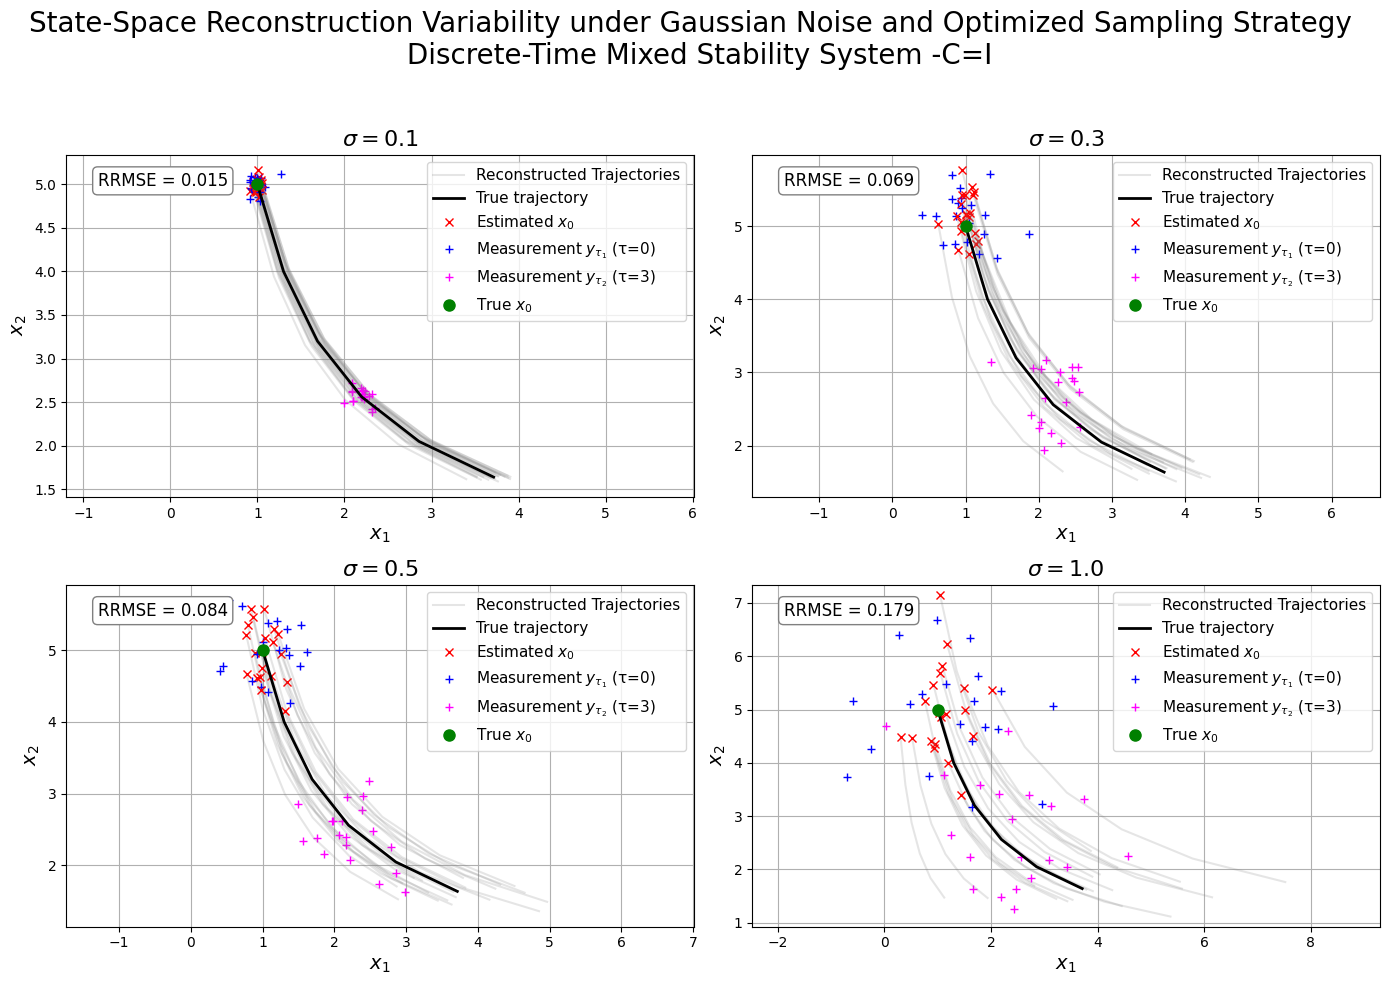

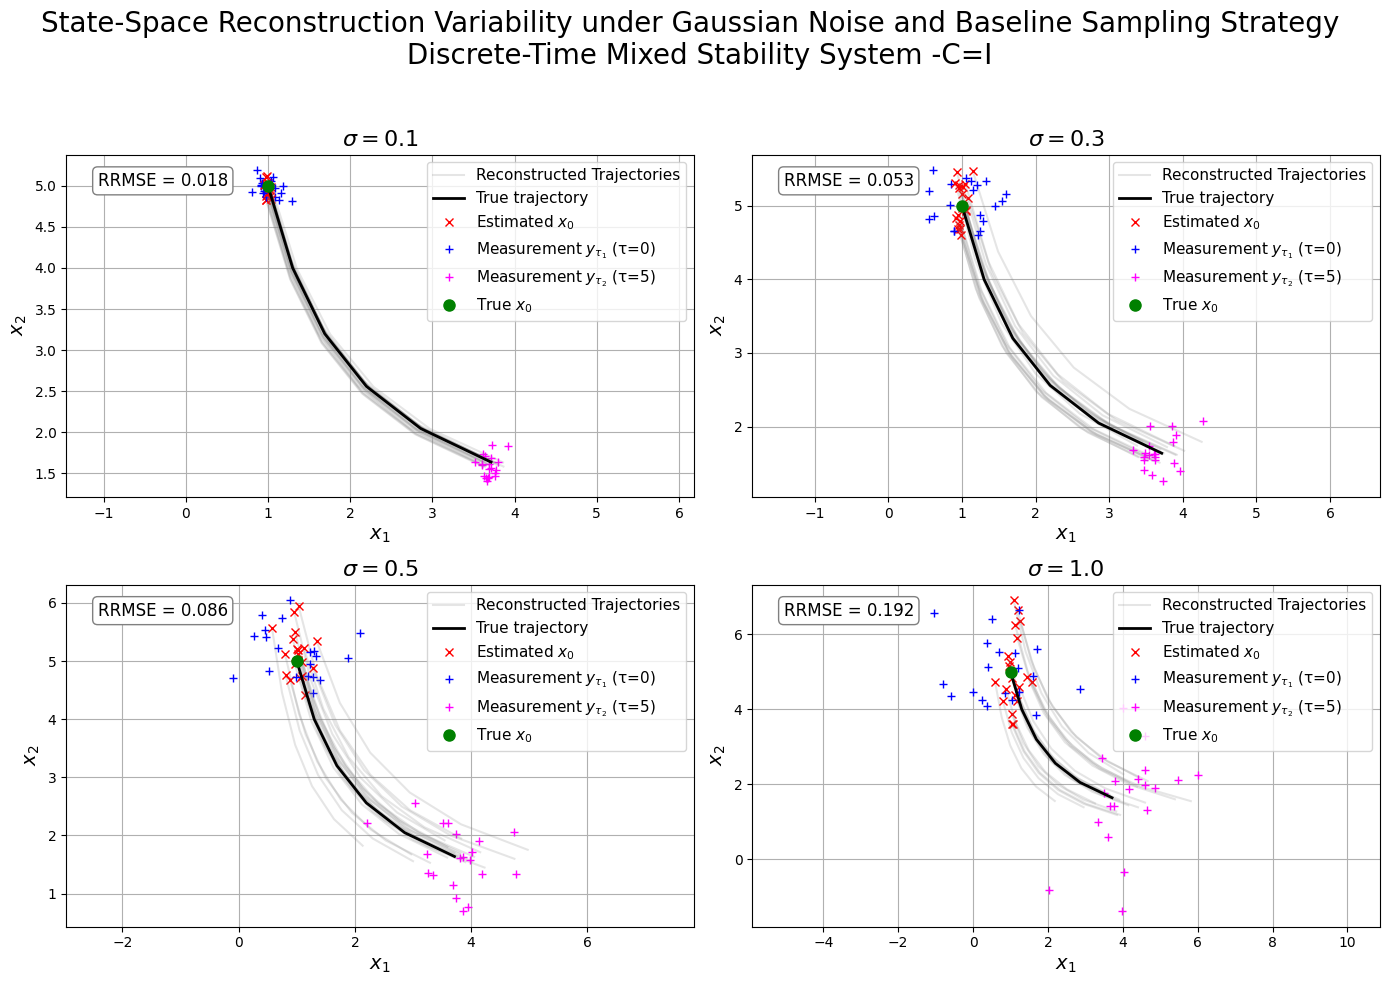

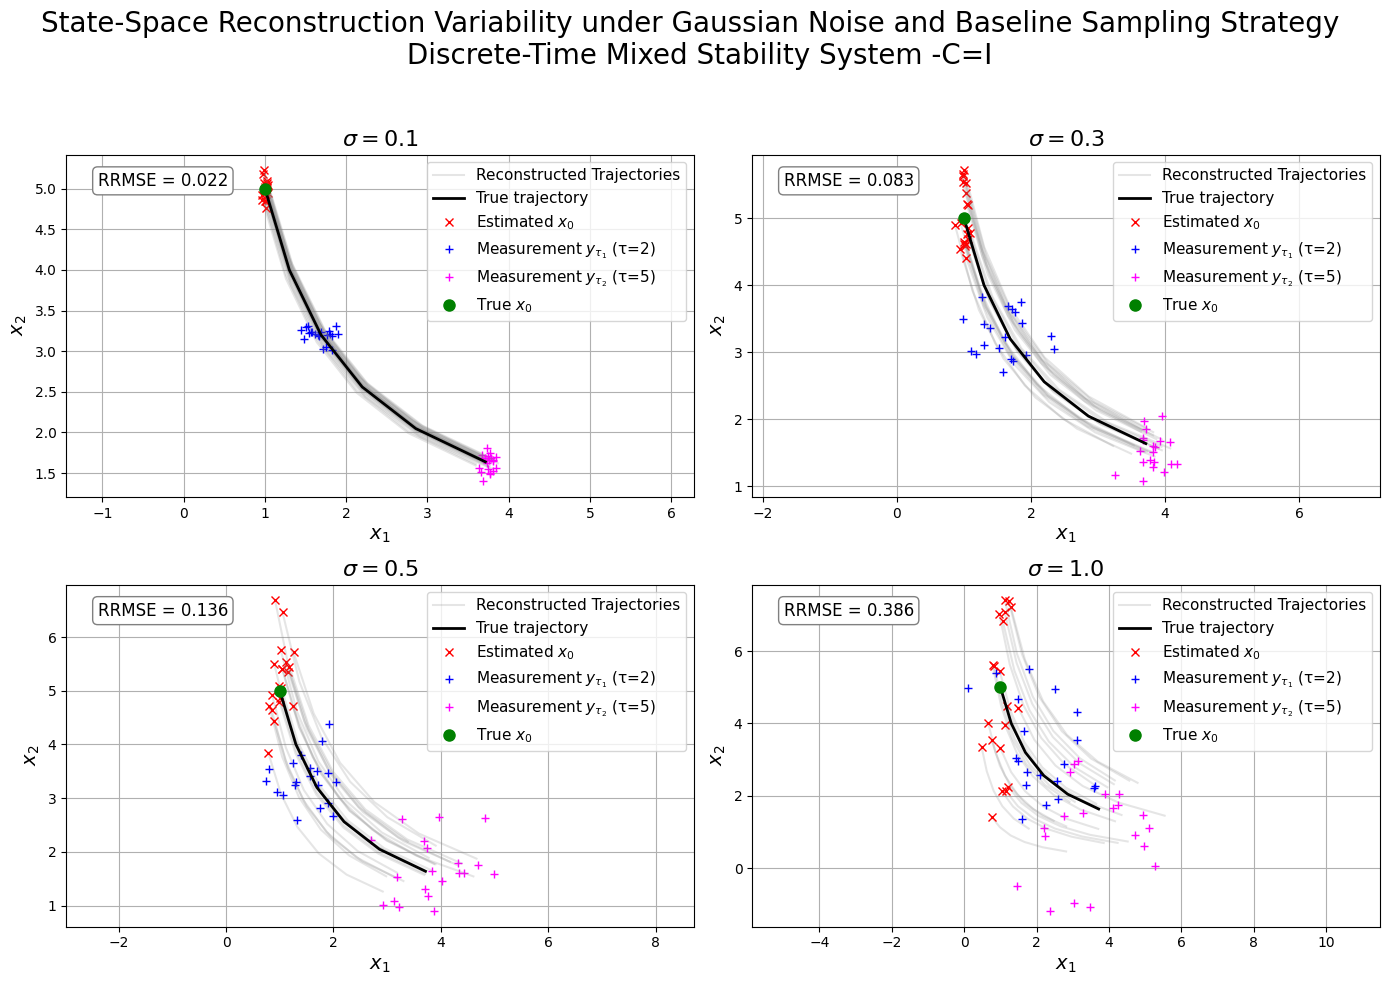

[np.float64(0.022082969093118927),
 np.float64(0.08292743883274484),
 np.float64(0.1361309945539137),
 np.float64(0.38564490479741126)]

In [ ]:
#Defining matrices
a11, a22 = 1.3, 0.8
A = np.diag([a11, a22])
C = np.eye(2)
T_max=5

#Solving
best_solutions = find_minimum_I(0, T_max, a11, a22)
print(best_solutions)
x0_true = np.array([1, 5])  #initial state
tau1, tau2 = best_solutions[0]



plot_state_space_variability(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Optimized Sampling Strategy', output='Mixed', Stability_case='Mixed Stability')


tau1, tau2= (0,5)
plot_state_space_variability(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Baseline Sampling Strategy', output='Mixed_1', Stability_case='Mixed Stability')

tau1, tau2= (2,5)
plot_state_space_variability(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Baseline Sampling Strategy', output='Mixed_2', Stability_case='Mixed Stability')


[(0, 0)]


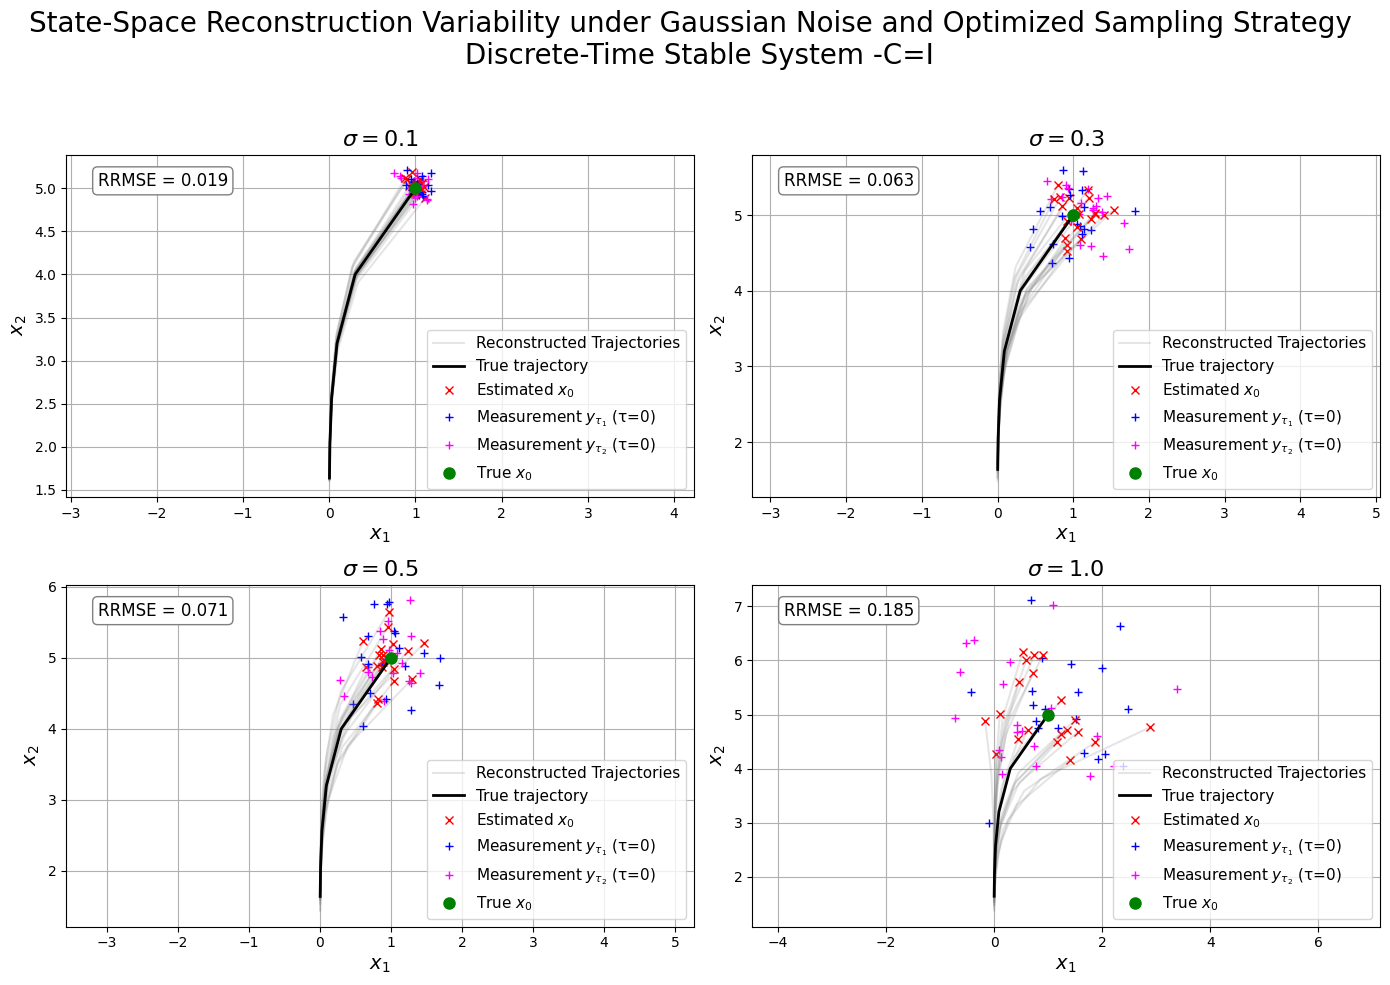

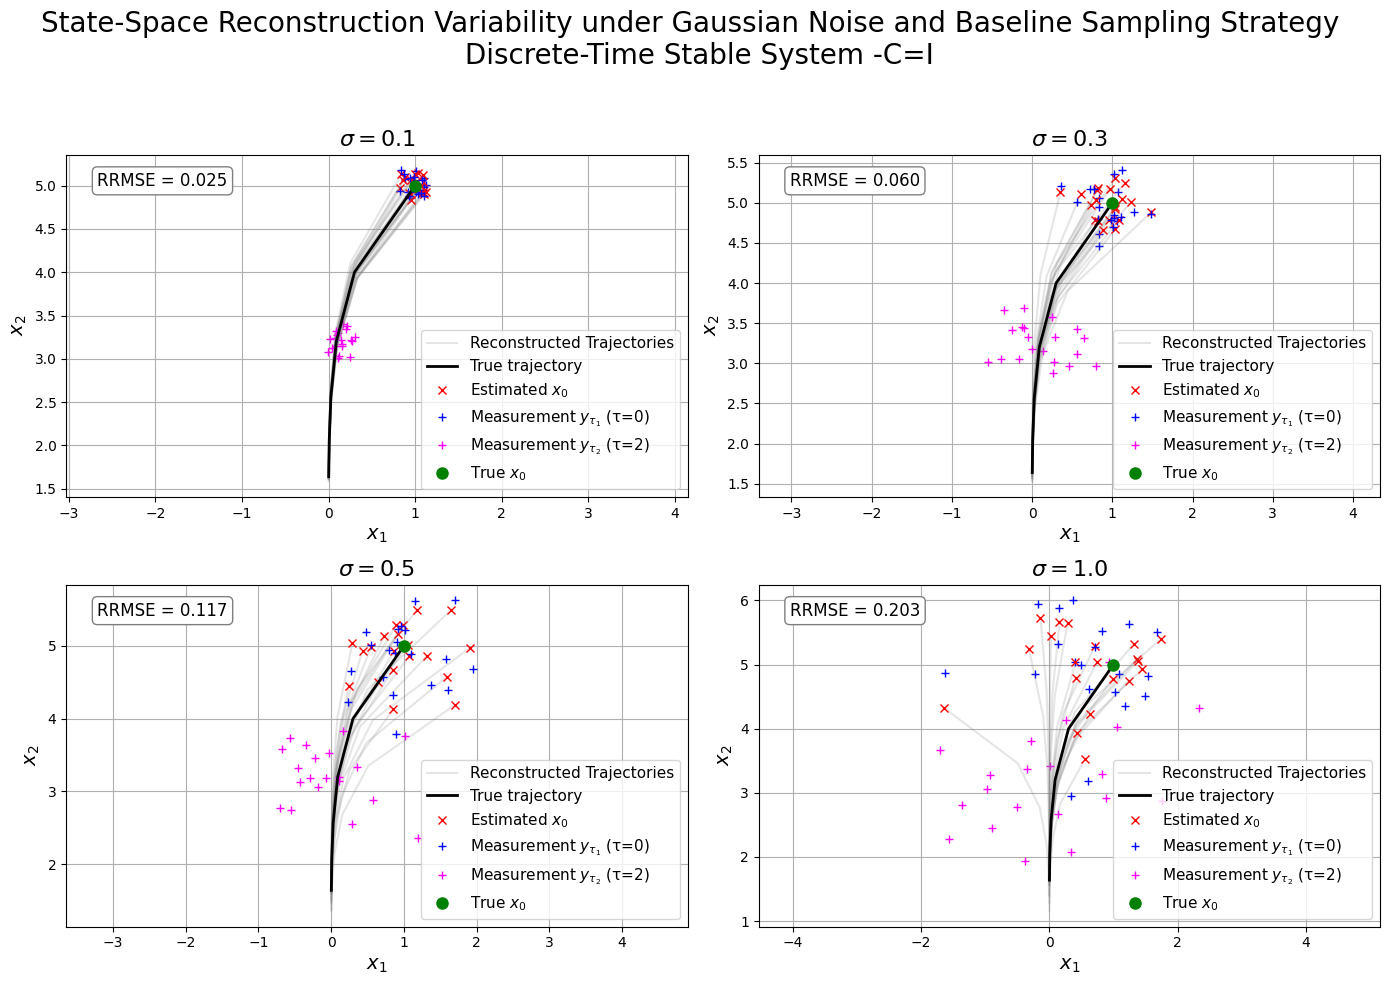

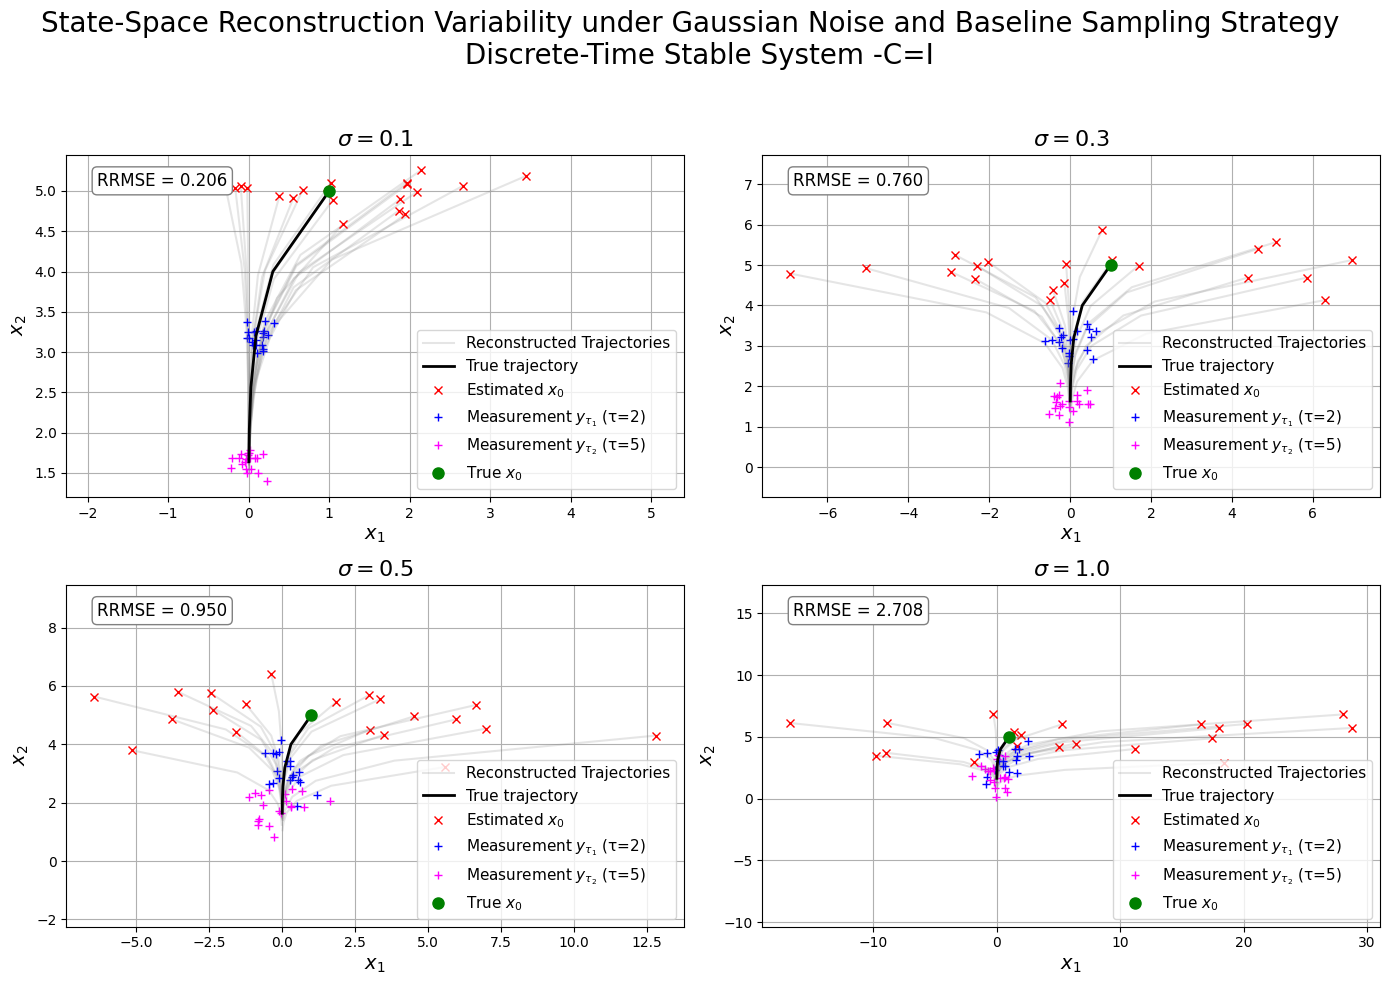

[np.float64(0.20573839451869588),
 np.float64(0.7603141886146784),
 np.float64(0.9501162808641104),
 np.float64(2.708207117621454)]

In [ ]:
#Defining matrices
a11, a22 = 0.3, 0.8
A = np.diag([a11, a22])
C = np.eye(2)
T_max=5

#Solving
best_solutions = find_minimum_I(0, T_max, a11, a22)
print(best_solutions)
x0_true = np.array([1, 5])  #initial state
tau1, tau2 = best_solutions[0]



plot_state_space_variability(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Optimized Sampling Strategy', output='Stable', Stability_case='Stable')


tau1, tau2= (0,2)
plot_state_space_variability(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Baseline Sampling Strategy', output='Stable_1', Stability_case='Stable')

tau1, tau2= (2,5)
plot_state_space_variability(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Baseline Sampling Strategy', output='Stable_2', Stability_case='Stable')



[(5, 5)]


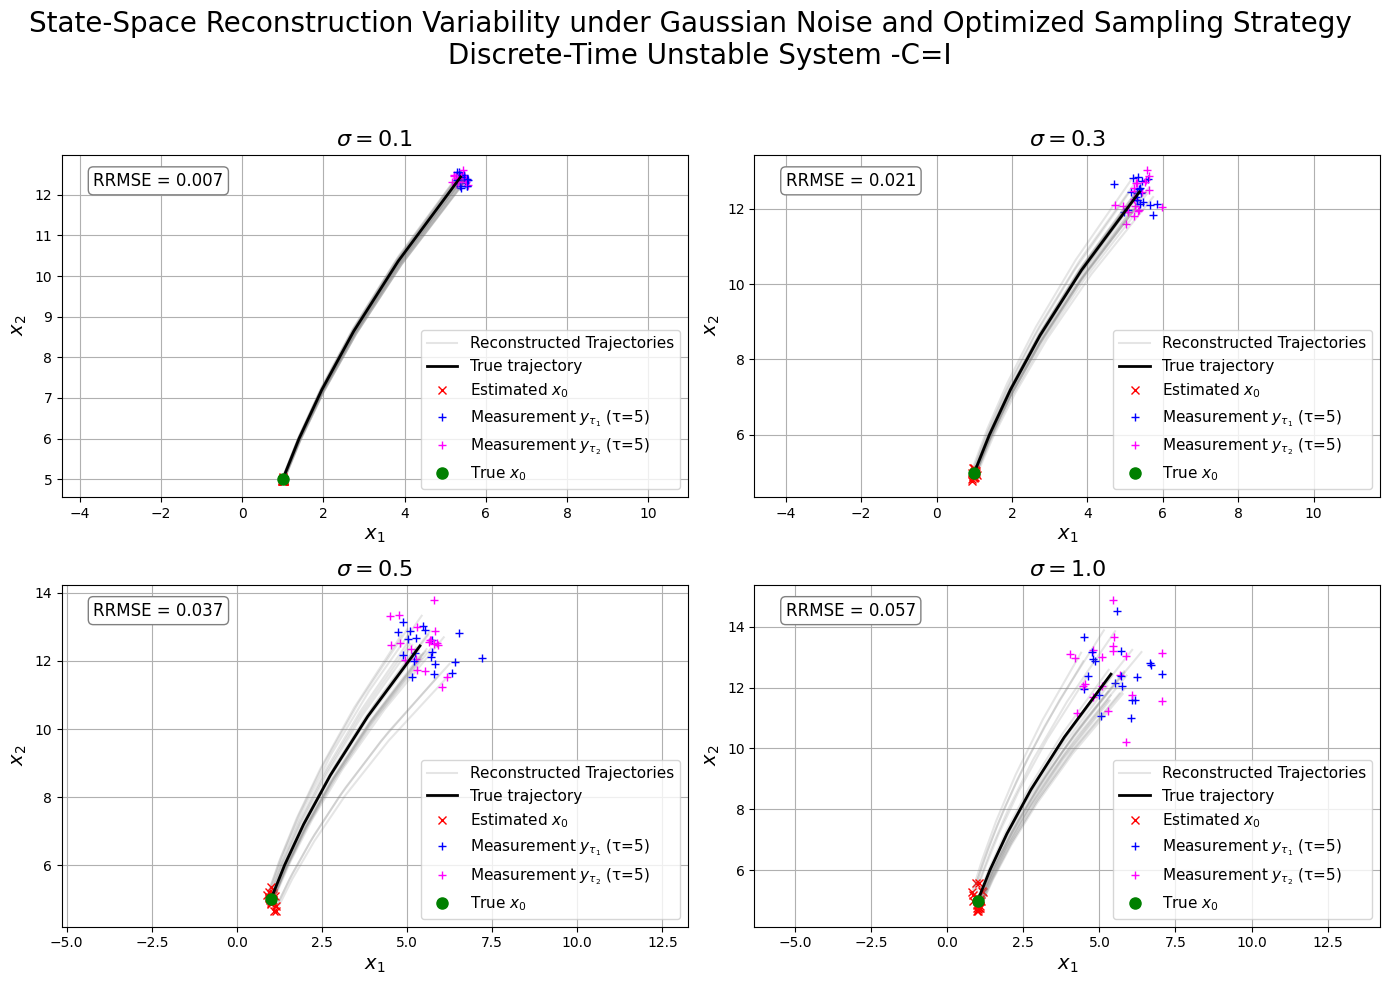

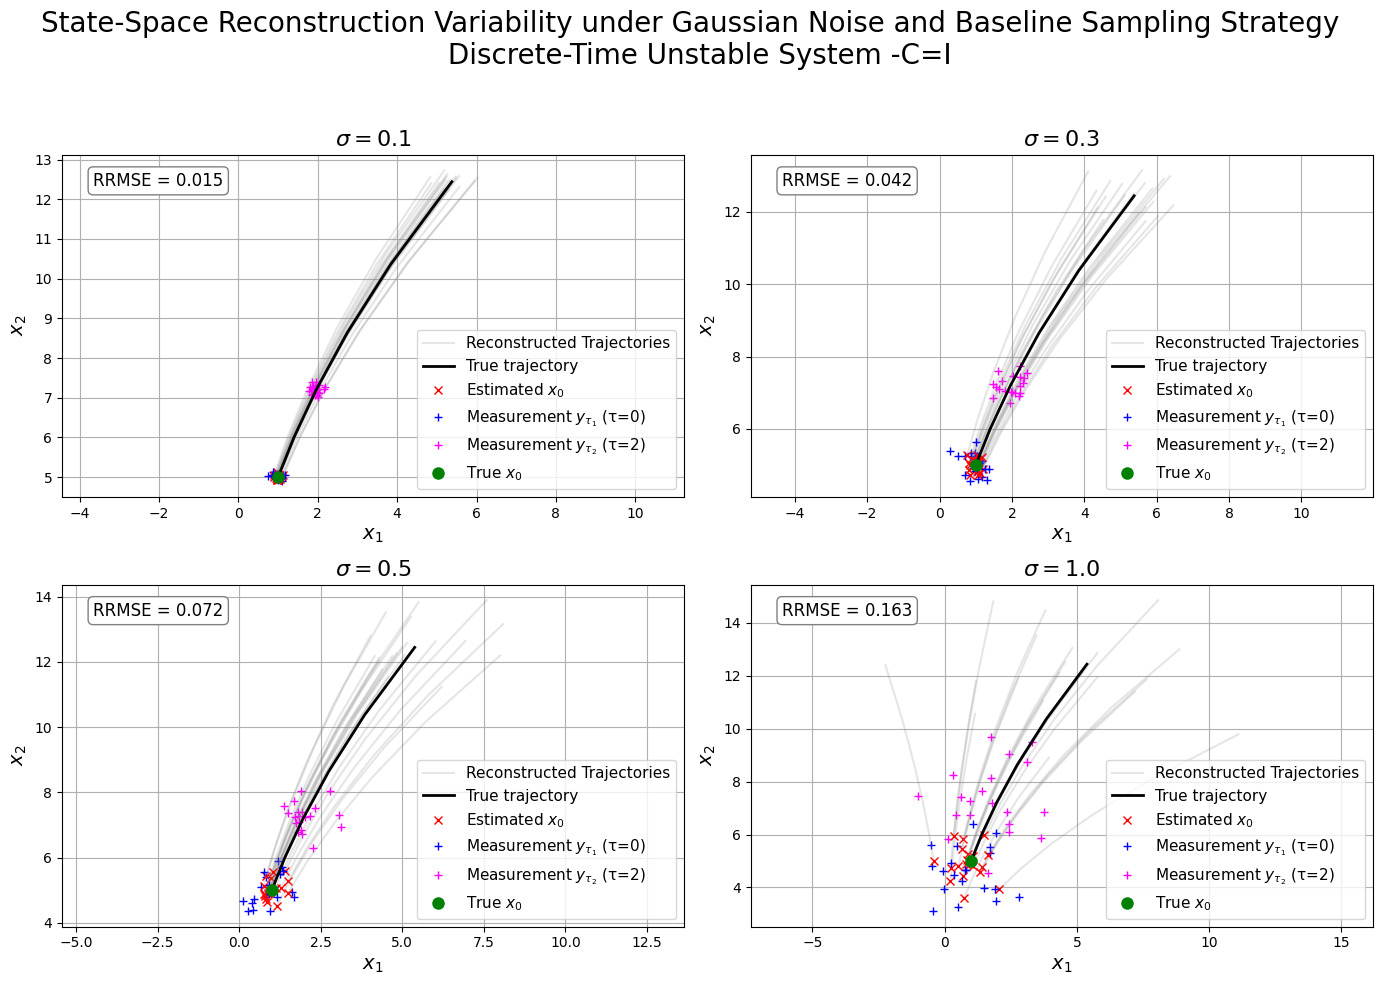

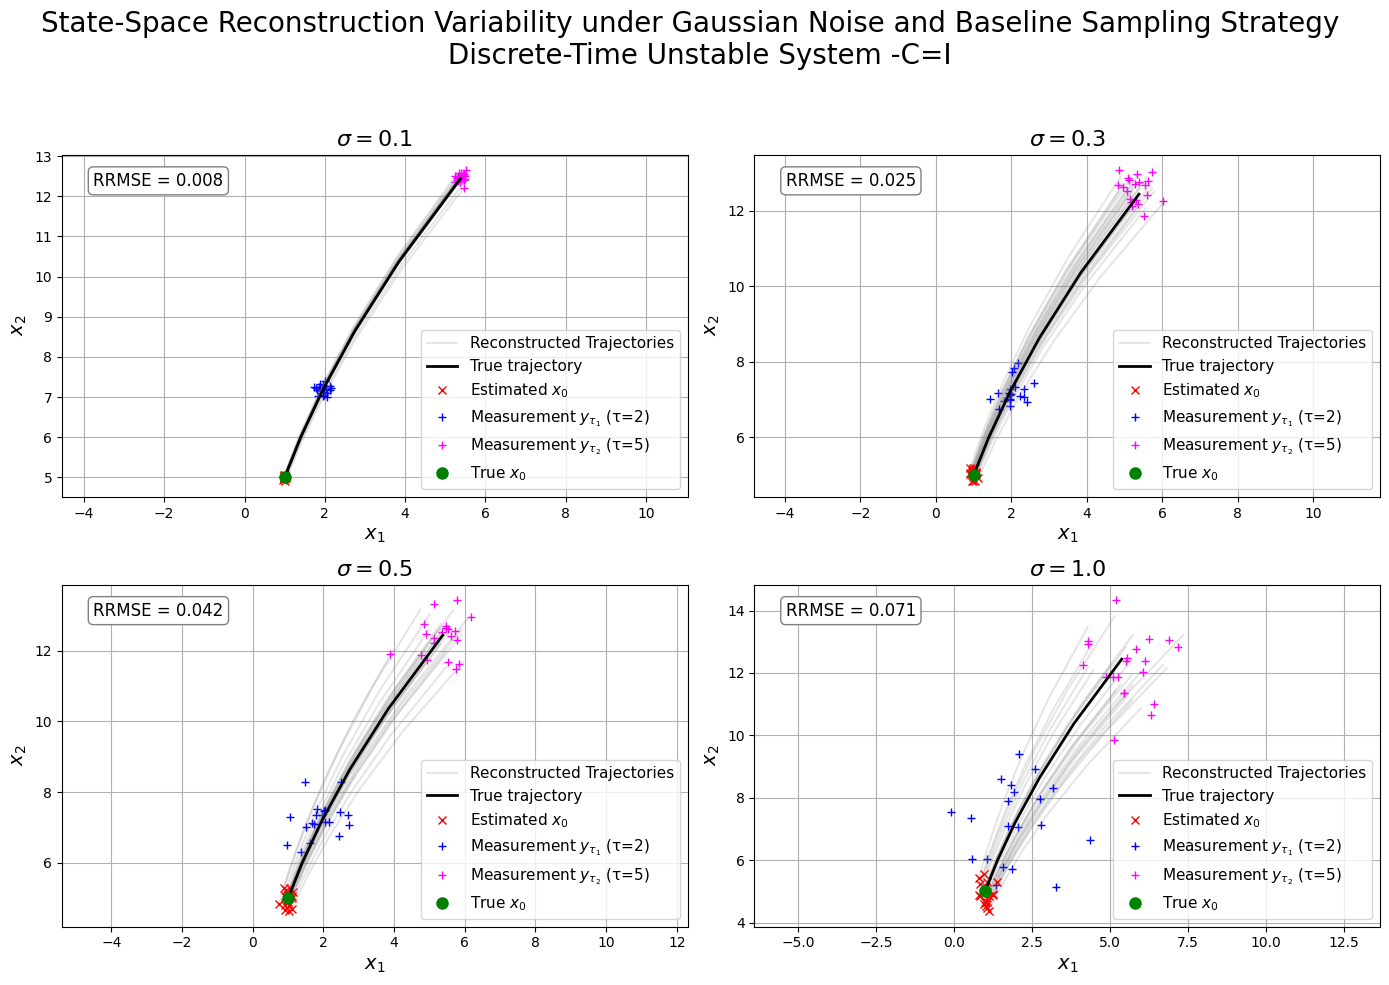

[np.float64(0.008254709740994395),
 np.float64(0.02471296148153154),
 np.float64(0.042009140768142134),
 np.float64(0.07098154298928477)]

In [ ]:
#Defining matrices
a11, a22 = 1.4, 1.2
A = np.diag([a11, a22])
C = np.eye(2)
T_max=5

#Solving
best_solutions = find_minimum_I(0, T_max, a11, a22)
print(best_solutions)
x0_true = np.array([1, 5])  #initial state
tau1, tau2 = best_solutions[0]



plot_state_space_variability(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Optimized Sampling Strategy', output='Unstable', Stability_case='Unstable')


tau1, tau2= (0,2)
plot_state_space_variability(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Baseline Sampling Strategy', output='Unstable_1', Stability_case='Unstable')

tau1, tau2= (2,5)
plot_state_space_variability(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Baseline Sampling Strategy', output='Unstbale_2', Stability_case='Unstable')



### DISCRETE Case where A is diagonal and C=[1 1]

In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
def f_1(tau1, tau2, a11, a22):
    num=a11**(2 * tau1) + a11**(2 * tau2)+ a22**(2 * tau1) + a22**(2 * tau2)
    denum= a11**(2 * tau1)*a22**(2 * tau2) + a11**(2 * tau2)*a22**(2 * tau1) - 2*a11**(tau1 + tau2) * a22**(tau1 + tau2)
    

    result = np.where(np.abs(a11 - a22) < 0.1, np.nan, num / denum)  # Mask near singularity
    
    return result

def find_minimum_1(tau_min, tau_max, a11, a22, resolution=50):
    best_solutions=[]
    best_value=np.inf
    for tau1 in range(tau_min, tau_max + 1):
        for tau2 in range(tau_min, tau_max + 1):
            if tau1==tau2:
                obj_value=np.inf
            else:
                obj_value = f_1(tau1, tau2, a11, a22)
            
            if obj_value < best_value:
                best_value = obj_value

    for tau1 in range(tau_min, tau_max + 1):
        for tau2 in range(tau_min, tau_max + 1):
            if tau1==tau2:
                obj_value=np.inf
            else:
                obj_value = f_1(tau1, tau2, a11, a22)
            
            if obj_value == best_value:
                best_solutions.append((tau1, tau2))
    return best_solutions

In [ ]:
#Measurement subspace
def plot_state_line(y, color, label):
    x_vals = np.linspace(0, 3, 100)
    y_vals = y - x_vals  # since y = x1 + x2 => x2 = y - x1
    plt.plot(x_vals, y_vals, linestyle='-', color=color, alpha=0.3, label=label)
    plt.scatter(x_vals, y_vals, s=5, color=color, alpha=0.2)

def plot_preimage_line(y, A_tau, color, label):
    # Solve: C A_tau x0 = y 
    # So we find all x0 satisfying this constraint
    C = np.array([1, 1])
    CA = C @ A_tau

    # x0 = [x1, x2], we want to plot the line CA @ x0 = y
    # If CA = [a b], then a x1 + b x2 = y_meas => x2 = (y_meas - a x1)/b
    a, b = CA[0], CA[1]

    x_vals = np.linspace(-0.3, 2, 100)
    if abs(b) > 1e-6:
        y_vals = (y - a * x_vals) / b #y_vals is for y-axis but corresponds to x2
        plt.plot(x_vals, y_vals, linestyle='-', color=color, alpha=0.5, label=label)
    else:
        # Vertical line: x = y / a
        x_line = y / a
        y_vals = np.linspace(-0.3, 2, 100)
        x_vals = np.full_like(y_vals, x_line)
        plt.plot(x_vals, y_vals, linestyle='--', color=color, alpha=0.5, label=label)

def plot_state_space_variability_I(A, C, tau1, tau2, x0_true, T=15, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, show_measurement_lines=False, Sampling_Strat='TO FILL', output=None, Stability_case='TO FILL'):
    A_tau1 = np.linalg.matrix_power(A, tau1)
    A_tau2 = np.linalg.matrix_power(A, tau2)
    x_traj_true = simulate_trajectory(A, x0_true, T)

    rrmse_list = []

    fig=plt.figure(figsize=(14, 10))

    for i, sigma in enumerate(sigmas, 1):
        plt.subplot(2, 2, i)
        y_tau1_list, y_tau2_list = [], []
        errors=[]

        for trial in range(trials):
            # Generate noisy scalar measurements
            y_tau1 = add_noise(C @ (A_tau1 @ x0_true), sigma).item()
            y_tau2 = add_noise(C @ (A_tau2 @ x0_true), sigma).item()

            y_tau1_list.append(y_tau1)
            y_tau2_list.append(y_tau2)

            if show_measurement_lines:
                plot_preimage_line(y_tau1, A_tau1, color="purple", label=f"$\\tau = {tau1}$ (noisy)" if trial == 0 else None)
                plot_preimage_line(y_tau2, A_tau2, color="orange", label=f"$\\tau = {tau2}$ (noisy)" if trial == 0 else None)

            # Reconstruct and simulate from estimated initial state
            x0_hat = reconstruct_initial_state(A, C, [tau1, tau2], [y_tau1, y_tau2])
            x_traj_hat = simulate_trajectory(A, x0_hat, T+5)

            errors.append(np.linalg.norm(x0_hat - x0_true)**2)

            plt.plot(x_traj_hat[:, 0], x_traj_hat[:, 1], alpha=0.35, color="grey", label='Reconstructed Trajectories' if trial == 0 else "")
            plt.plot(x0_hat[0], x0_hat[1], 'x', color="red", markersize=6)

        # Plot true trajectory
        plt.plot(x_traj_true[:, 0], x_traj_true[:, 1], color="black", linewidth=2, label="True trajectory")
        plt.plot(x0_true[0], x0_true[1], 'o', color="green", markersize=8, label="True $x_0$")

         # Compute and store RRMSE 
        mse = np.mean(errors)
        rrmse = np.sqrt(mse) / np.linalg.norm(x0_true)
        rrmse_list.append(rrmse)

        plt.text(
            0.75, 0.95, f"RRMSE = {rrmse:.3f}",
            transform=plt.gca().transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
        )

        # Mean preimage lines
        y_tau1_mean = np.mean(y_tau1_list)
        y_tau2_mean = np.mean(y_tau2_list)
        plot_preimage_line(y_tau1_mean, A_tau1, "blue", f"Mean line $\\tau={tau1}$")
        plot_preimage_line(y_tau2_mean, A_tau2, "magenta", f"Mean line $\\tau={tau2}$")


        
        handles, labels = plt.gca().get_legend_handles_labels()

        # Separate by type
        line_handles = []
        line_labels = []
        marker_handles = []
        marker_labels = []

        for h, l in zip(handles, labels):
            if isinstance(h, plt.Line2D):
                if h.get_linestyle() != "None":  
                    line_handles.append(h)
                    line_labels.append(l)
                else:  
                    marker_handles.append(h)
                    marker_labels.append(l)

        
        ordered_handles = line_handles + marker_handles
        ordered_labels = line_labels + marker_labels

        plt.legend(ordered_handles, ordered_labels, loc="lower left", fontsize=11)

        plt.title(rf"$\sigma = {sigma}$", fontsize=16)
        plt.xlabel("$x_1$", fontsize=14)
        plt.ylabel("$x_2$", fontsize=14)
        plt.axis("equal")
        plt.grid(True)
    
    fig.suptitle(f'State-Space Reconstruction Variability under Gaussian Noise and {Sampling_Strat} \n Discrete-Time {Stability_case} System - C=[1  1]', fontsize=20)
    # fig.suptitle(f'Variability of Measurement Lines - {Sampling_Strat} \n Discrete-Time {Stability_case} System - C=[1  1]', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    safe_strat = Sampling_Strat.replace(" ", "_").replace("/", "_")
    filename = f"../plots/State_Reconstruction/DT/Reconstruction_11_{safe_strat[:4]}_{output}.pdf"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


[(0, 4), (4, 0)]


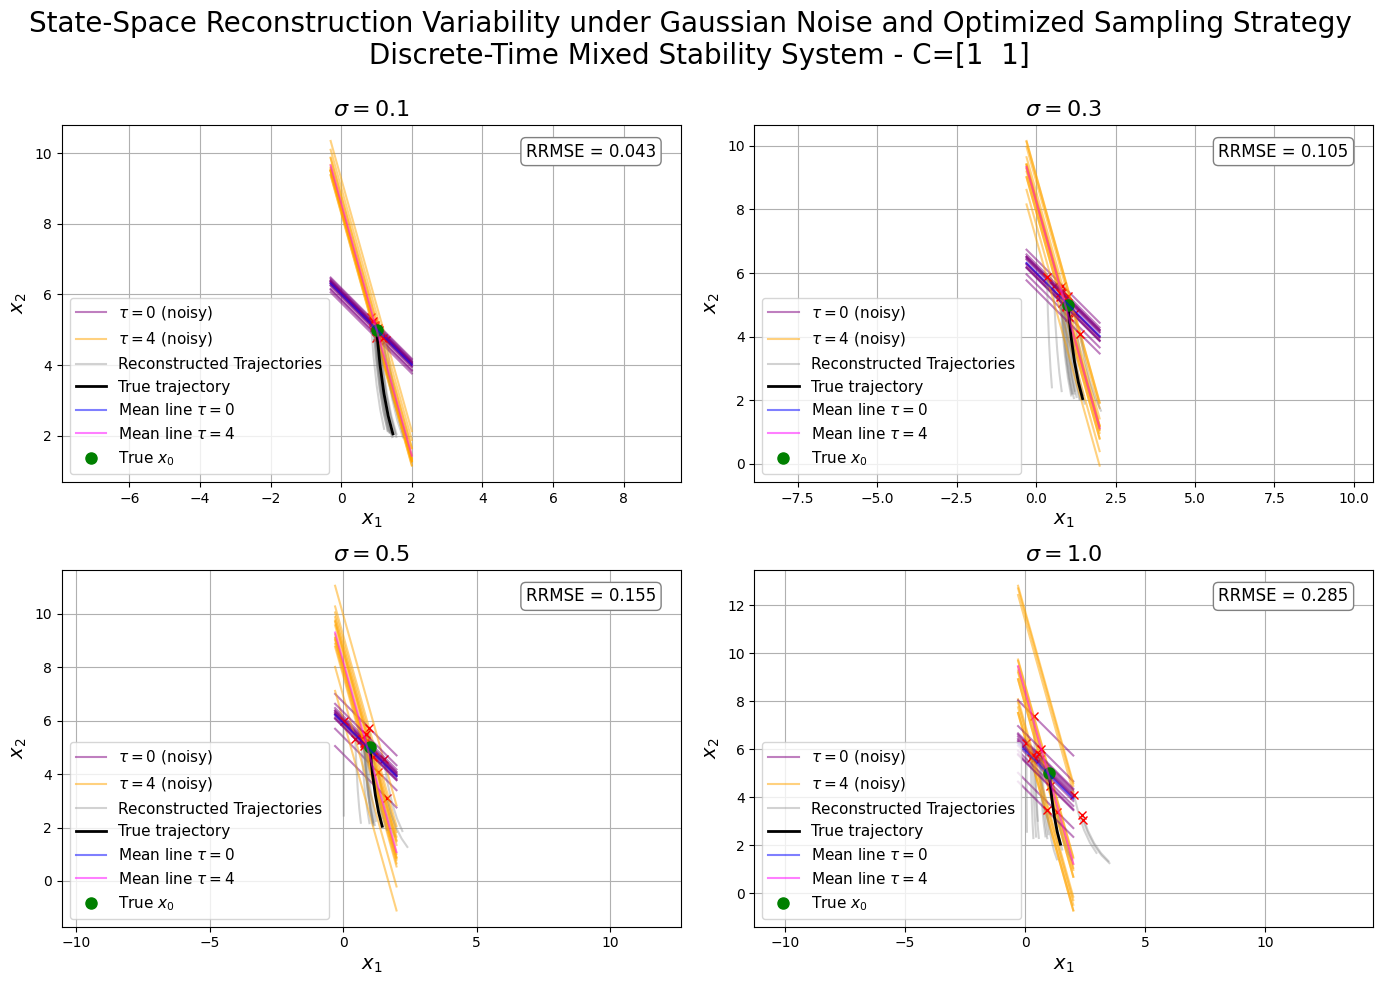

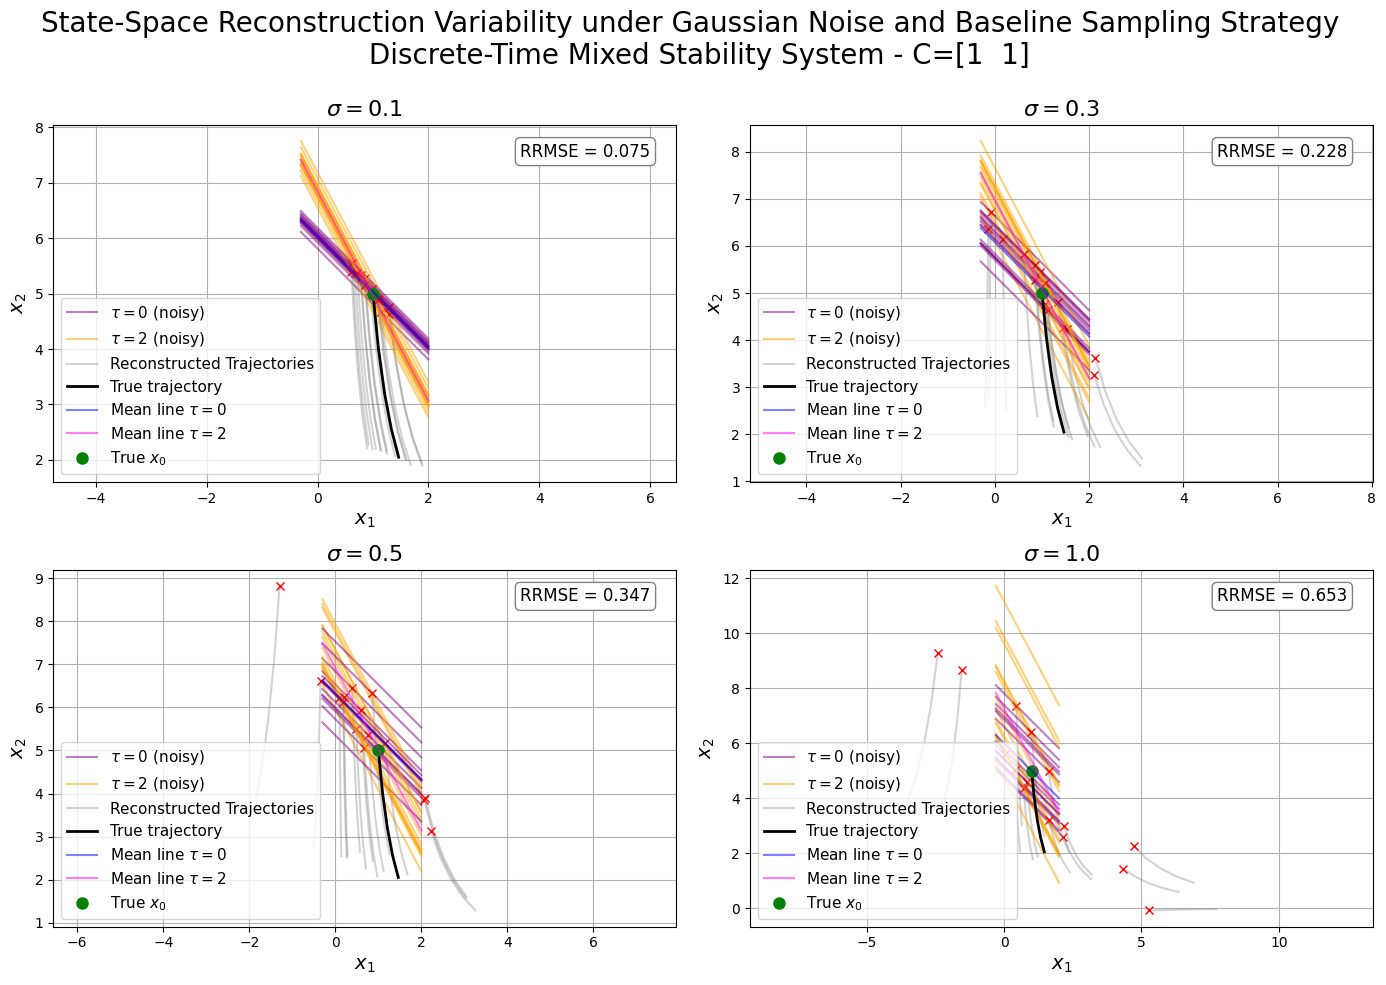

In [ ]:
a11, a22 = 1.1, 0.8
A = np.diag([a11, a22])
C = np.array([1, 1])
T_max=4

#Solving
best_solutions = find_minimum_1(0, T_max, a11, a22)
print(best_solutions)
x0_true = np.array([1, 5])  # initial state
tau1, tau2 = best_solutions[0]

# tau1, tau2= (2,4)


plot_state_space_variability_I(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=15, show_measurement_lines= True, Sampling_Strat='Optimized Sampling Strategy', output='Mixed_Variance', Stability_case= 'Mixed Stability')


tau1, tau2= (0,2)


plot_state_space_variability_I(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=15, show_measurement_lines= True, Sampling_Strat='Baseline Sampling Strategy', output='Mixed_Variance', Stability_case= 'Mixed Stability')


[(2, 4), (4, 2)]


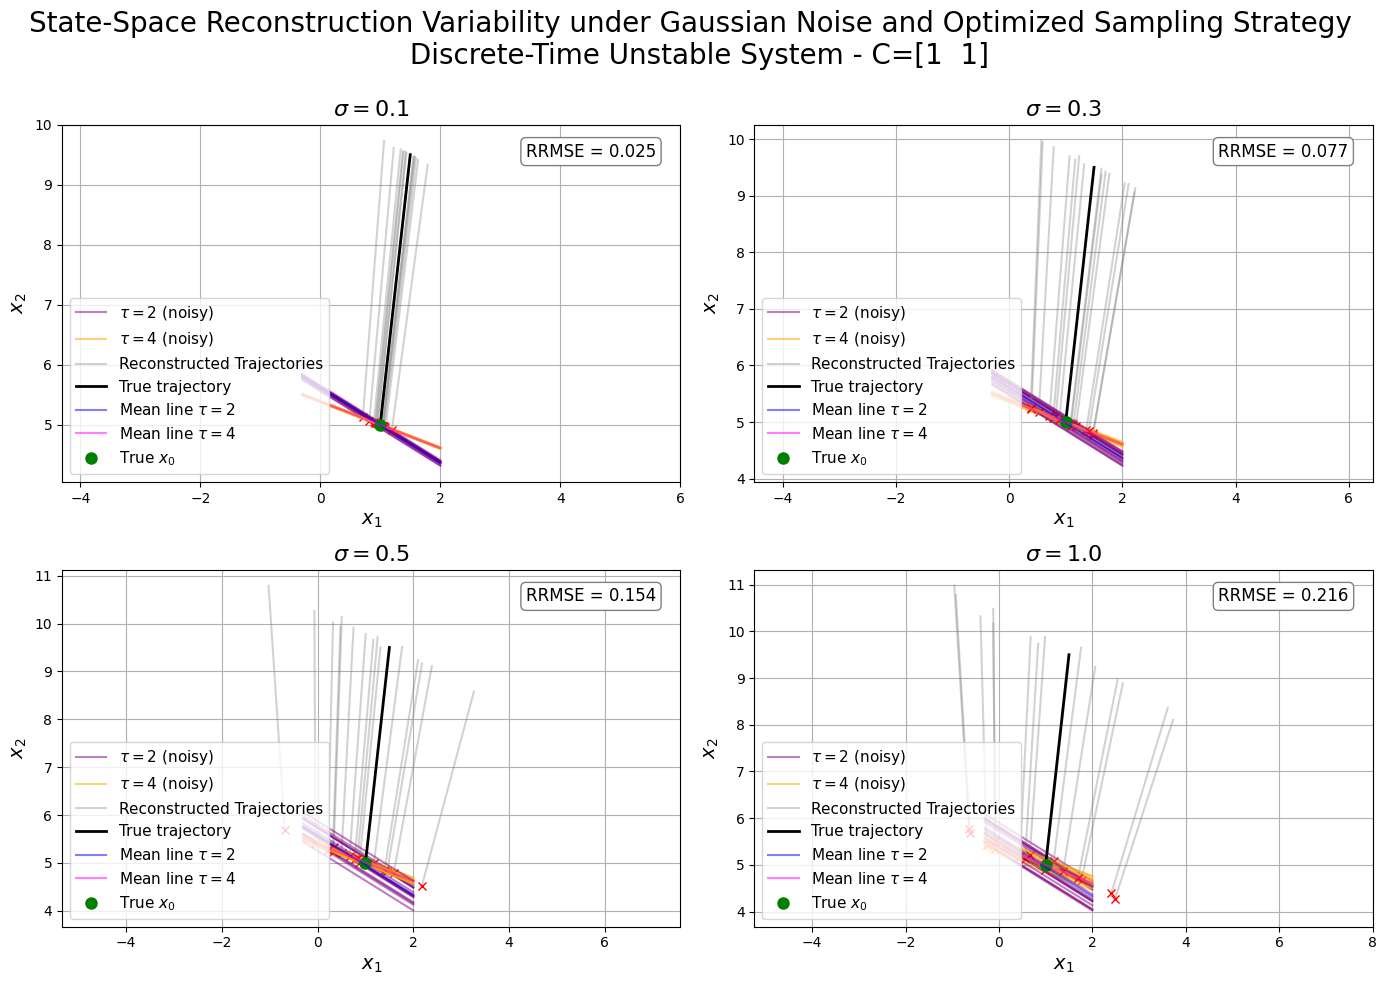

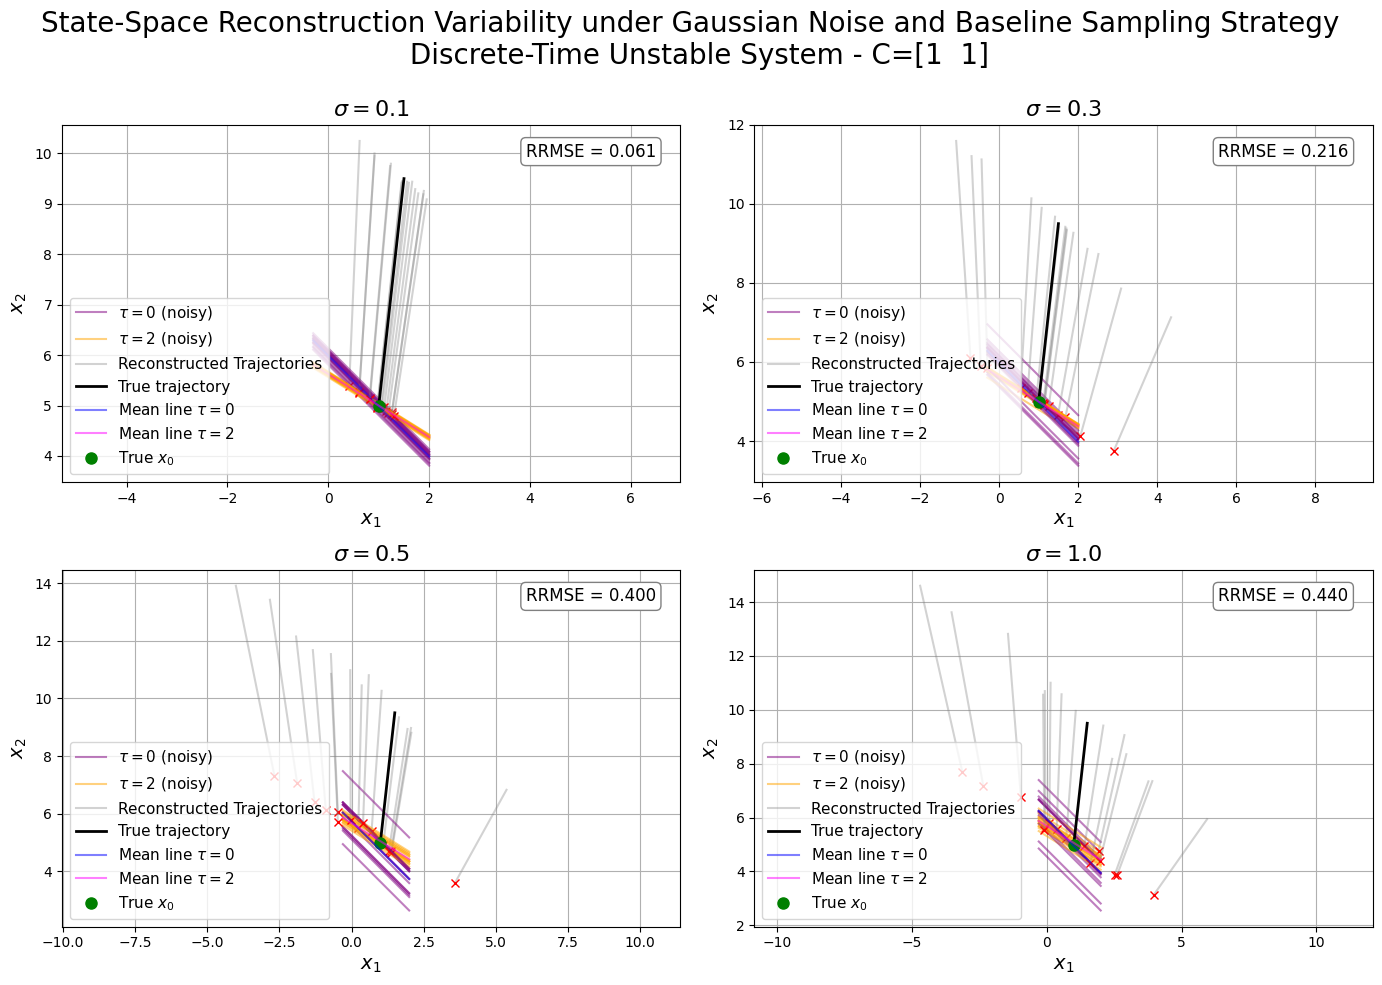

In [ ]:
a11, a22 = 1.5, 1.9
A = np.diag([a11, a22])
C = np.array([1, 1])
T_max=4

#Solving
best_solutions = find_minimum_1(0, T_max, a11, a22)
print(best_solutions)
x0_true = np.array([1, 5])  #initial state
tau1, tau2 = best_solutions[0]

# tau1, tau2= (2,4)


plot_state_space_variability_I(A,C, tau1, tau2, x0_true, T=T_max-3, sigmas=[0.1, 0.3, 0.5, 1.0], trials=15, show_measurement_lines= True, Sampling_Strat='Optimized Sampling Strategy', output='Unstable_Variance', Stability_case= 'Unstable')


tau1, tau2= (0,2)


plot_state_space_variability_I(A,C, tau1, tau2, x0_true, T=T_max-3, sigmas=[0.1, 0.3, 0.5, 1.0], trials=15,show_measurement_lines= True, Sampling_Strat='Baseline Sampling Strategy', output='Unstable_Variance', Stability_case= 'Unstable')

[(0, 1)]


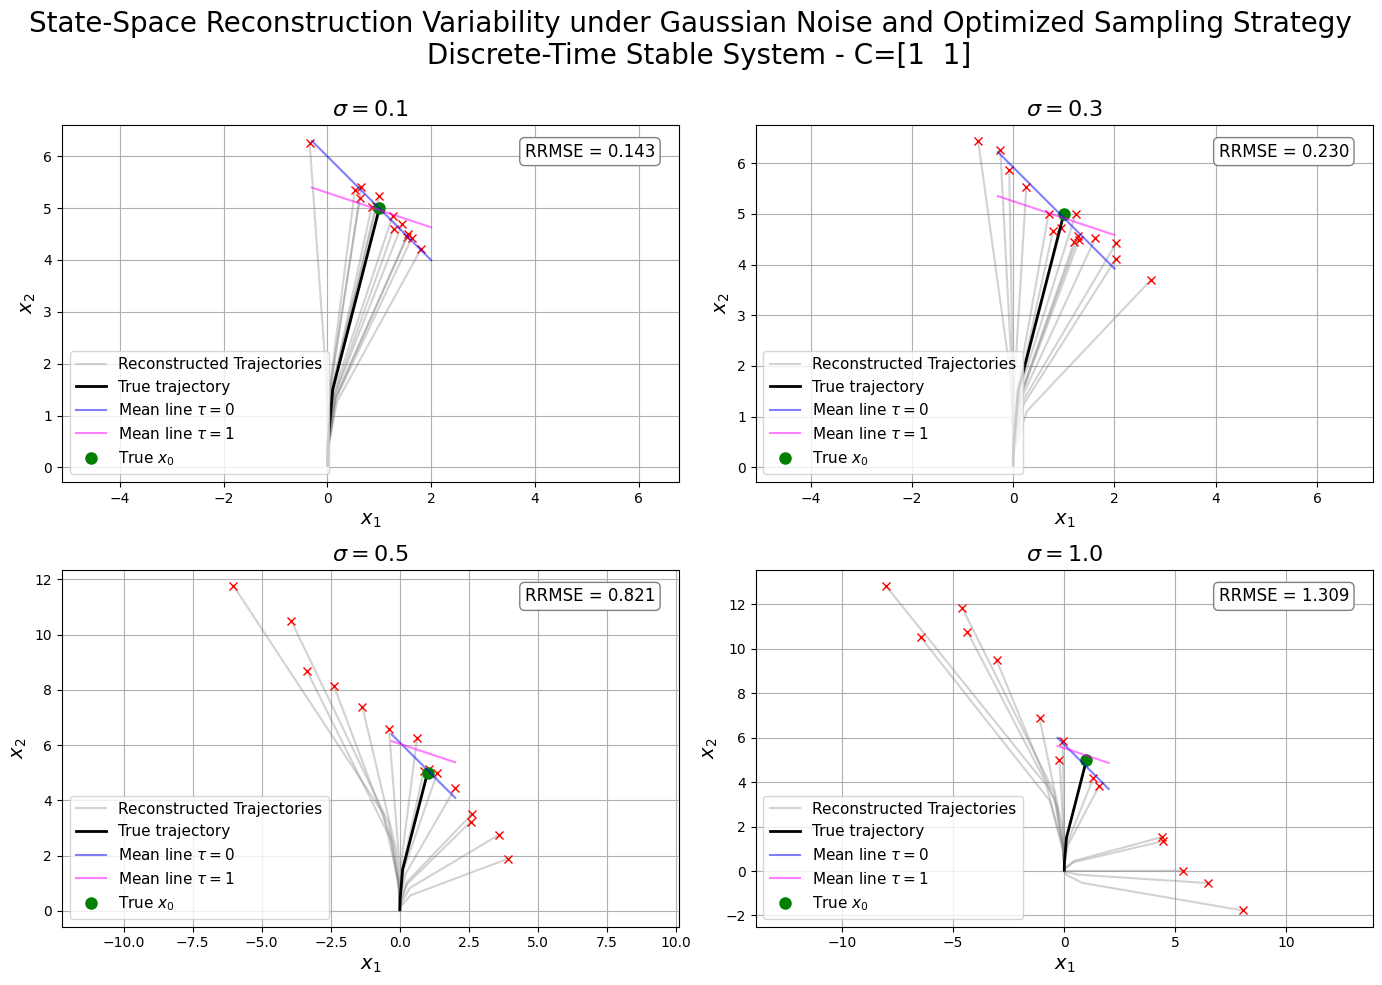

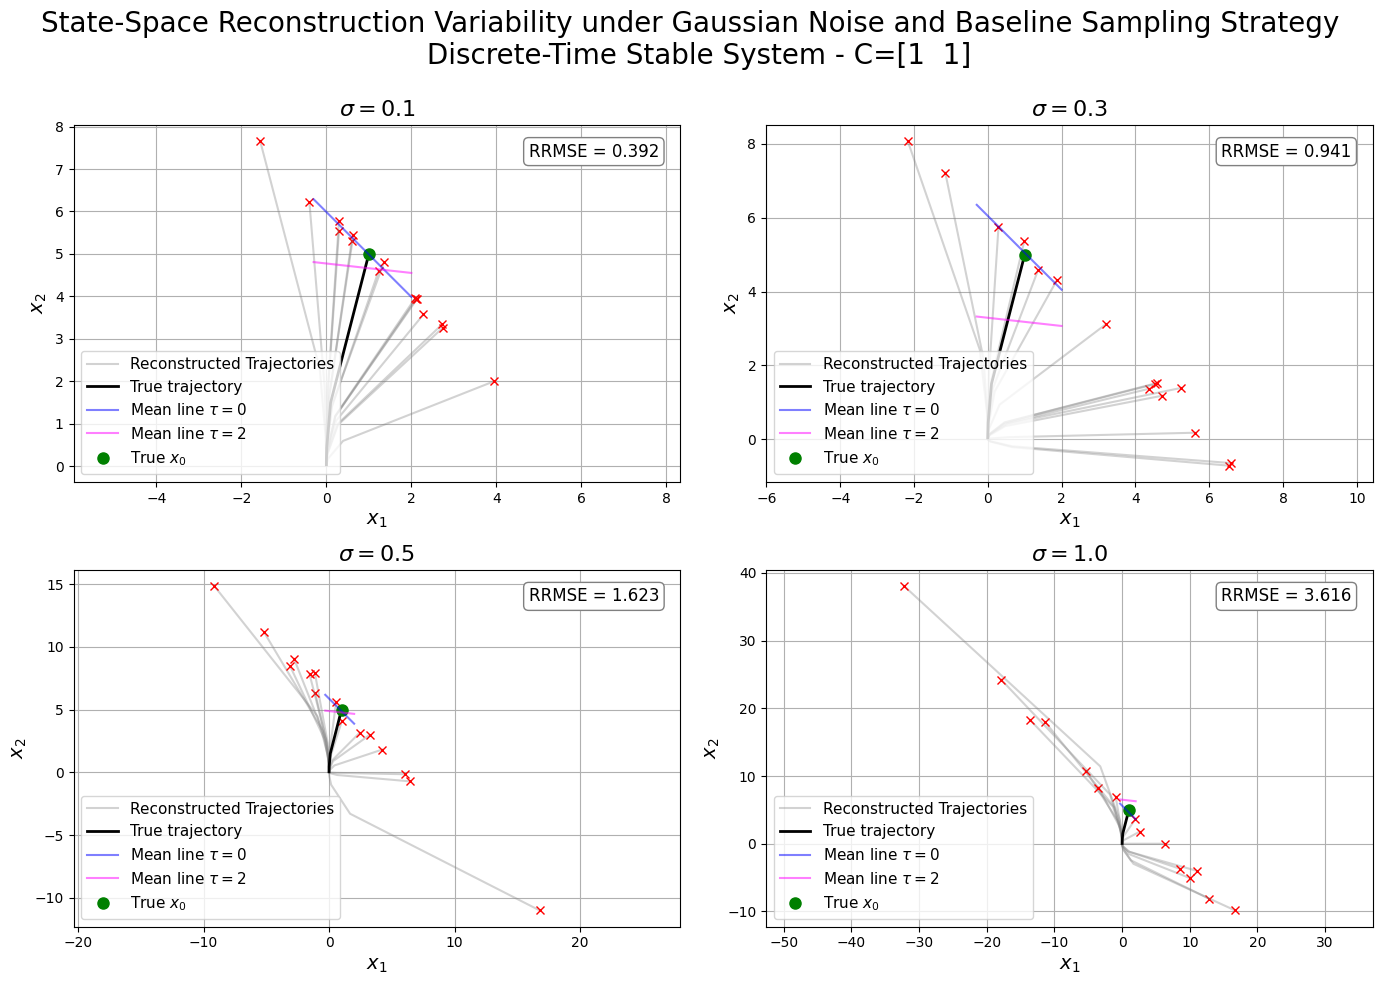

In [ ]:
a11, a22 = 0.1, 0.3
A = np.diag([a11, a22])
C = np.array([1, 1])
T_max=4

#Solving
best_solutions = find_minimum_1(0, T_max, a11, a22)
print(best_solutions)
x0_true = np.array([1, 5])  #initial state
tau1, tau2 = best_solutions[0]

# tau1, tau2= (2,4)


plot_state_space_variability_I(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=15, Sampling_Strat='Optimized Sampling Strategy', output='Stable', Stability_case='Stable')
# plot_state_space_variability_I(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1], trials=15, show_measurement_lines= True, Sampling_Strat='Optimized Sampling Strategy', output='Stable_Variance', Stability_case='Stable')
tau1, tau2= (0,2)


plot_state_space_variability_I(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=15,  Sampling_Strat='Baseline Sampling Strategy', output='Stable', Stability_case= 'Stable')
# plot_state_space_variability_I(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1], trials=15, show_measurement_lines= True,  Sampling_Strat='Baseline Sampling Strategy', output='Stable_Variance', Stability_case= 'Stable')

In [ ]:
def f_Im(A, C, tau1, tau2):
    taus = [int(tau1), int(tau2)]

    # Initialize Gramian
    W = np.zeros((A.shape[0], A.shape[0]))

    for tau in taus:
        A_tau = np.linalg.matrix_power(A, tau)
        term = A_tau.T @ C.T @ C @ A_tau
        W += term

    # Regularization if W is near-singular
    try:
        W_inv = np.linalg.inv(W)
    except np.linalg.LinAlgError:
        print("Warning: Gramian is singular or ill-conditioned; adding small regularization.")
        W += 1e-8 * np.eye(W.shape[0])
        W_inv = np.linalg.inv(W)

    return np.trace(W_inv)

def find_minimum_Im(tau_min, tau_max, A, C, resolution=50):
    best_solutions=[]
    best_value=np.inf
    for tau1 in range(tau_min, tau_max + 1):
        for tau2 in range(tau_min, tau_max + 1):
            if tau1==tau2:
                obj_value=np.inf
            else:
                obj_value = f_Im(A, C, tau1, tau2)
            
            if obj_value < best_value:
                best_value = obj_value

    for tau1 in range(tau_min, tau_max + 1):
        for tau2 in range(tau_min, tau_max + 1):
            if tau1==tau2:
                obj_value=np.inf
            else:
                obj_value = f_Im(A, C, tau1, tau2)
            
            if obj_value == best_value:
                best_solutions.append((tau1, tau2))
    return best_solutions


[(9, 19), (19, 9)]


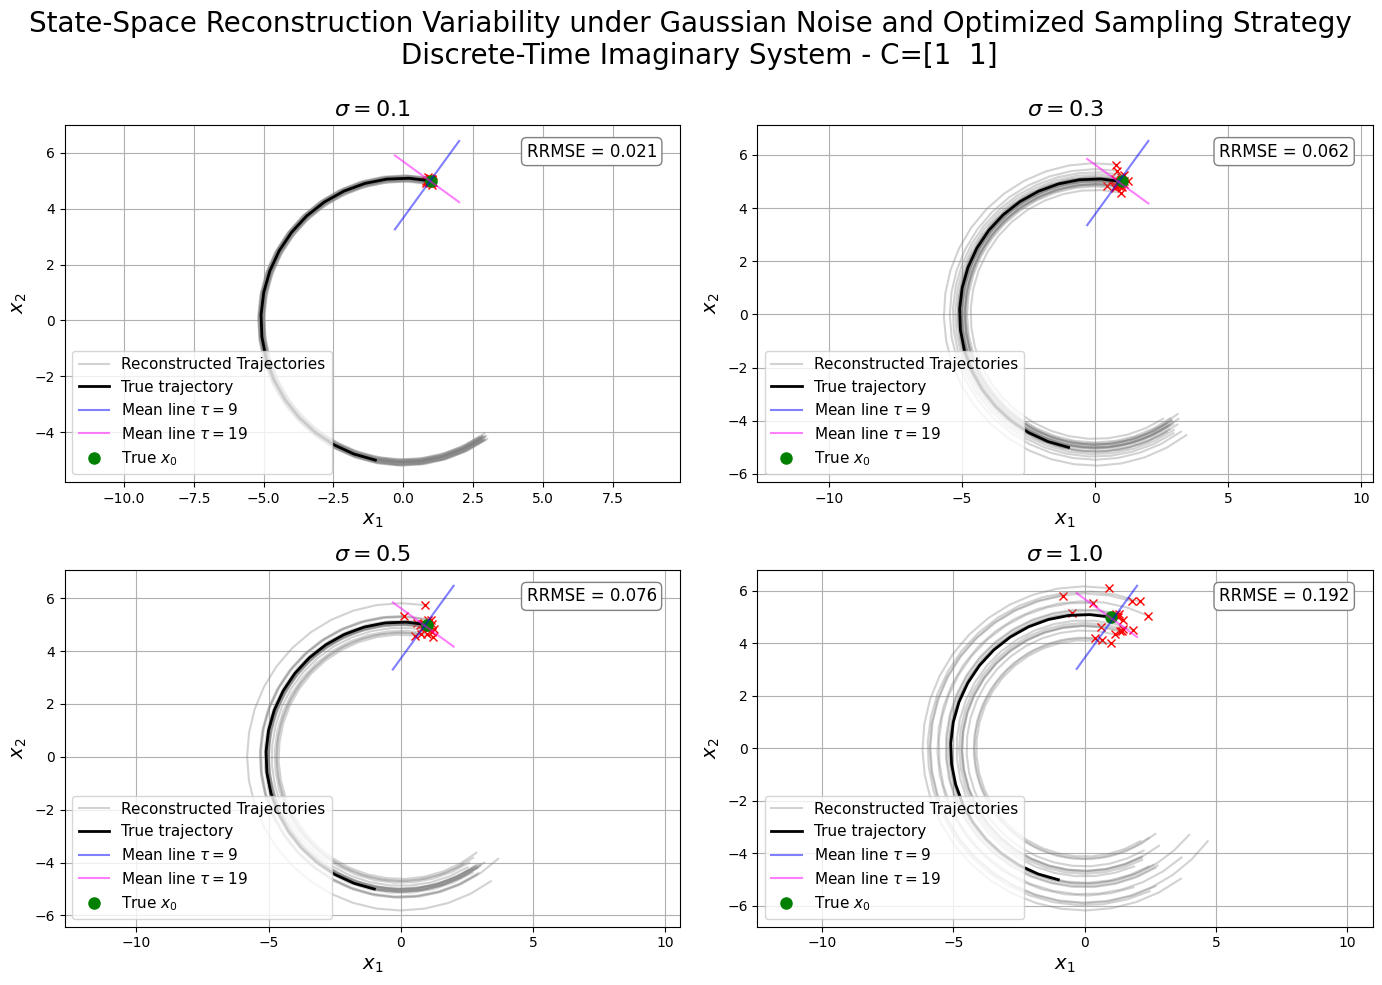

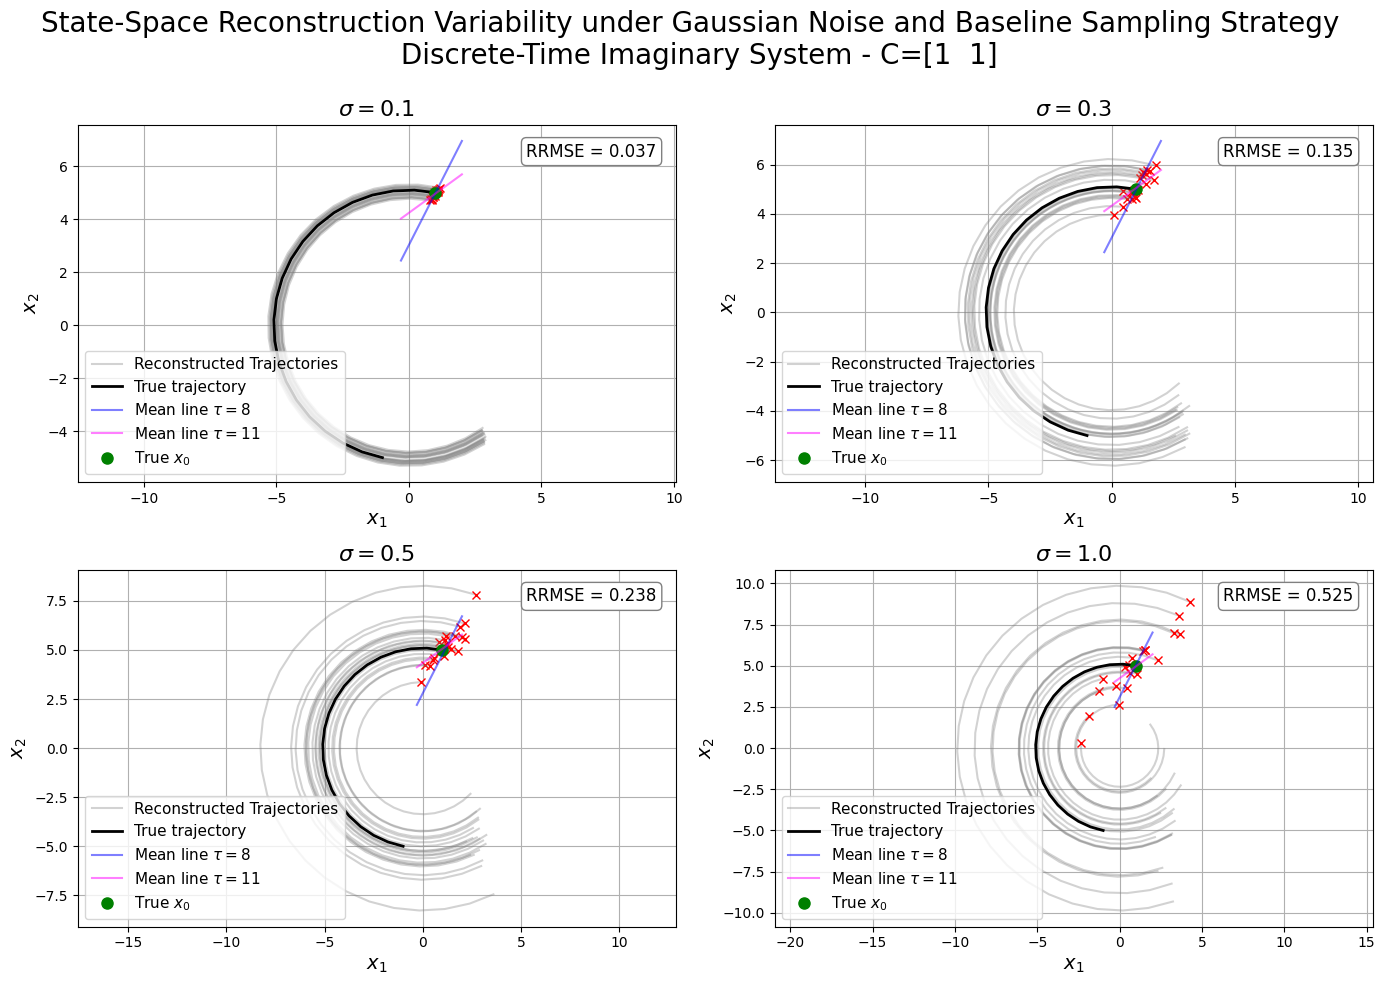

In [ ]:
import random

theta = np.pi / 20
A = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])
C=np.array([1, 1])
C_r = C.reshape((1, 2))

T_max=20
#Solving
best_solutions = find_minimum_Im(0, T_max, A, C_r)
print(best_solutions)

x0_true = np.array([1, 5])  #initial state
tau1, tau2 = best_solutions[0]


plot_state_space_variability_I(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Optimized Sampling Strategy', output='Imaginary', Stability_case='Imaginary')

tau1, tau2 = (random.randint(0,20),random.randint(0,20))


plot_state_space_variability_I(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20, Sampling_Strat='Baseline Sampling Strategy', output='Imaginary', Stability_case='Imaginary')

### Continuous Case where A is diagonal and C=[1 1]

In [ ]:
import numpy as np
from scipy.linalg import expm

def simulate_trajectory_continuous(A, x0, T, dt=0.1):
    x_traj = [x0]
    for t in range(1, T+1):
        t_val = t * dt
        x_traj.append(expm(A * t_val) @ x0)
    return np.array(x_traj)

def add_noise(y, sigma=0.1):
    return y + np.random.normal(0, sigma, size=y.shape)

def reconstruct_initial_state_continuous(A, C, taus, y_meas):
    # Observability matrix using continuous-time 
    Phi = np.vstack([C @ expm(A * tau) for tau in taus])
    
    # Stack noisy measurements
    y_stack = np.hstack(y_meas)
    
    # Least squares solution using pseudoinverse
    Phi_pinv = np.linalg.pinv(Phi)
    x0_hat = Phi_pinv @ y_stack
    return x0_hat.flatten()



In [147]:
from math import exp

def f_1_continuous(tau1, tau2, a11, a22):
    num= exp(a11*2*tau1) + exp(a11*2*tau2) + exp(a22*2*tau1) + exp(a22*2*tau2)
    denum= (exp(a11*tau1 + a22*tau2) - exp(a11*tau2 + a22*tau1))**2
    

    result = np.where(np.abs(a11 - a22) < 0.1, np.nan, num / denum)  # Mask near singularity
    
    return result

def find_minimum_1_continuous(tau_min, tau_max, a11, a22, resolution=50):
    best_solutions=[]
    best_value=np.inf
    tau1_vals= np.linspace(tau_min,tau_max,100)
    tau2_vals= np.linspace(tau_min,tau_max,100)

    for tau1 in tau1_vals:
        for tau2 in tau2_vals:
            if tau1==tau2:
                obj_value=np.inf
            else:
                obj_value = f_1_continuous(tau1, tau2, a11, a22)
            
            if obj_value < best_value:
                best_value = obj_value

    for tau1 in tau1_vals:
        for tau2 in tau2_vals:
            if tau1==tau2:
                obj_value=np.inf
            else:
                obj_value = f_1_continuous(tau1, tau2, a11, a22)
            
            if obj_value == best_value:
                best_solutions.append((tau1, tau2))
    return best_solutions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

def plot_preimage_line_continuous(y, A_tau, color, label):
    C = np.array([1, 1])
    CA = C @ A_tau
    a, b = CA[0], CA[1]

    x_vals = np.linspace(-0.3, 2, 100)
    if abs(b) > 1e-6:
        y_vals = (y - a * x_vals) / b
        plt.plot(x_vals, y_vals, linestyle='--', color=color, alpha=0.5, label=label)
    else:
        x_line = y / a
        y_vals = np.linspace(-0.3, 2, 100)
        x_vals = np.full_like(y_vals, x_line)
        plt.plot(x_vals, y_vals, linestyle='--', color=color, alpha=0.5, label=label)

def plot_state_space_variability_I_continuous(A, C, tau1, tau2, x0_true, T=15, dt=0.1, sigmas=[0.1, 0.3, 0.5, 1.0], trials=20,show_measurement_lines=False, Sampling_Strat='TO FILL', output=None ):
    A_tau1 = expm(A * tau1)
    A_tau2 = expm(A * tau2)

    # Simulate true continuous-time trajectory
    x_traj_true = [expm(A * (i * dt)) @ x0_true for i in range(T + 1)]
    x_traj_true = np.array(x_traj_true)

    fig= plt.figure(figsize=(12, 10))

    for i, sigma in enumerate(sigmas, 1):
        plt.subplot(2, 2, i)
        y_tau1_list, y_tau2_list = [], []

        for trial in range(trials):
            # Generate noisy scalar measurements
            y_tau1 = add_noise(C @ (A_tau1 @ x0_true), sigma).item()
            y_tau2 = add_noise(C @ (A_tau2 @ x0_true), sigma).item()

            y_tau1_list.append(y_tau1)
            y_tau2_list.append(y_tau2)

            if show_measurement_lines:
                plot_preimage_line(y_tau1, A_tau1, color="purple", label=f"$\\tau = {tau1}$ (noisy)" if trial == 0 else None)
                plot_preimage_line(y_tau2, A_tau2, color="orange", label=f"$\\tau = {tau2}$ (noisy)" if trial == 0 else None)

            # Reconstruct and simulate from estimated initial state
            x0_hat = reconstruct_initial_state_continuous(A, C, [tau1, tau2], [y_tau1, y_tau2])
            x_traj_hat = simulate_trajectory_continuous(A, x0_hat, T)
            plt.plot(x_traj_hat[:, 0], x_traj_hat[:, 1], alpha=0.35, color="grey", label='Reconstructed Trajectories' if trial == 0 else "")
            plt.plot(x0_hat[0], x0_hat[1], 'x', color="red", markersize=6)

        # Plot true trajectory
        plt.plot(x_traj_true[:, 0], x_traj_true[:, 1], color="black", linewidth=2, label="True trajectory")
        plt.plot(x0_true[0], x0_true[1], 'o', color="green", markersize=8, label="True $x_0$")

        # Mean preimage lines
        y_tau1_mean = np.mean(y_tau1_list)
        y_tau2_mean = np.mean(y_tau2_list)
        plot_preimage_line(y_tau1_mean, A_tau1, "blue", f"Mean line $\\tau={tau1}$")
        plot_preimage_line(y_tau2_mean, A_tau2, "magenta", f"Mean line $\\tau={tau2}$")



        handles, labels = plt.gca().get_legend_handles_labels()

        # Separate by type
        line_handles = []
        line_labels = []
        marker_handles = []
        marker_labels = []

        for h, l in zip(handles, labels):
            if isinstance(h, plt.Line2D):
                if h.get_linestyle() != "None": 
                    line_handles.append(h)
                    line_labels.append(l)
                else:  
                    marker_handles.append(h)
                    marker_labels.append(l)

        ordered_handles = line_handles + marker_handles
        ordered_labels = line_labels + marker_labels

        plt.legend(ordered_handles, ordered_labels, loc="upper right", fontsize=9)

        plt.title(rf"Measurement noise $\sigma = {sigma}$", fontsize=12)
        plt.xlabel("$x_1$", fontsize=11)
        plt.ylabel("$x_2$", fontsize=11)
        plt.axis("equal")
        plt.grid(True)

    
    fig.suptitle(f'State-Space Reconstruction Variability under Gaussian Noise and {Sampling_Strat} \n Discrete-Time System - C=[1  1]', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    safe_strat = Sampling_Strat.replace(" ", "_").replace("/", "_")
    filename = f"../plots/State_Reconstruction/CT/Reconstruction_11_{safe_strat[:4]}_{output}.pdf"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()




[(np.float64(0.0), np.float64(5.0)), (np.float64(5.0), np.float64(0.0))]


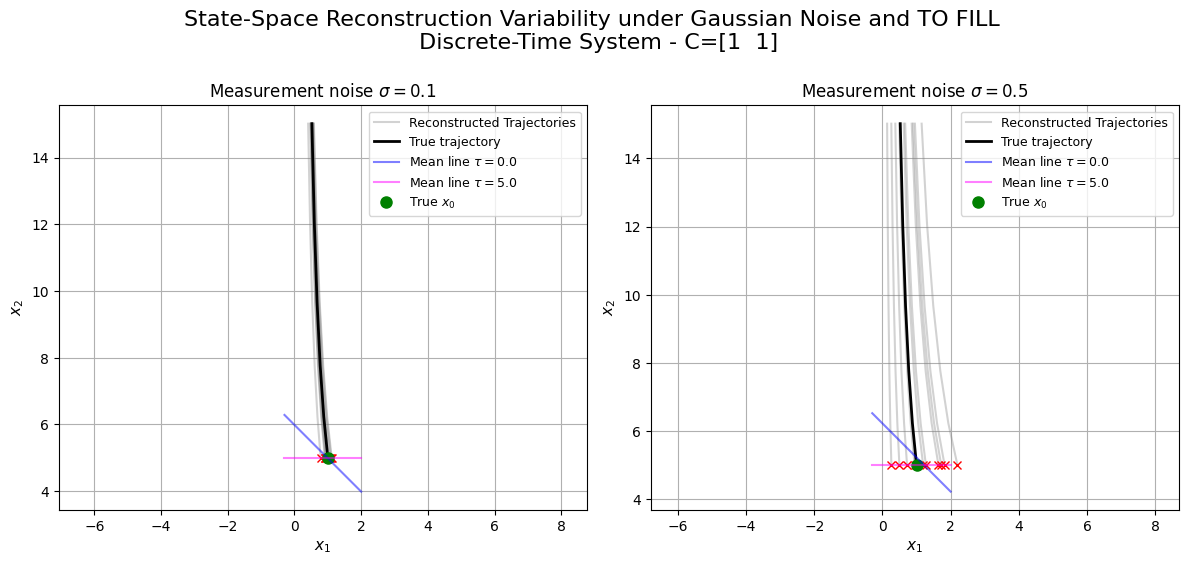

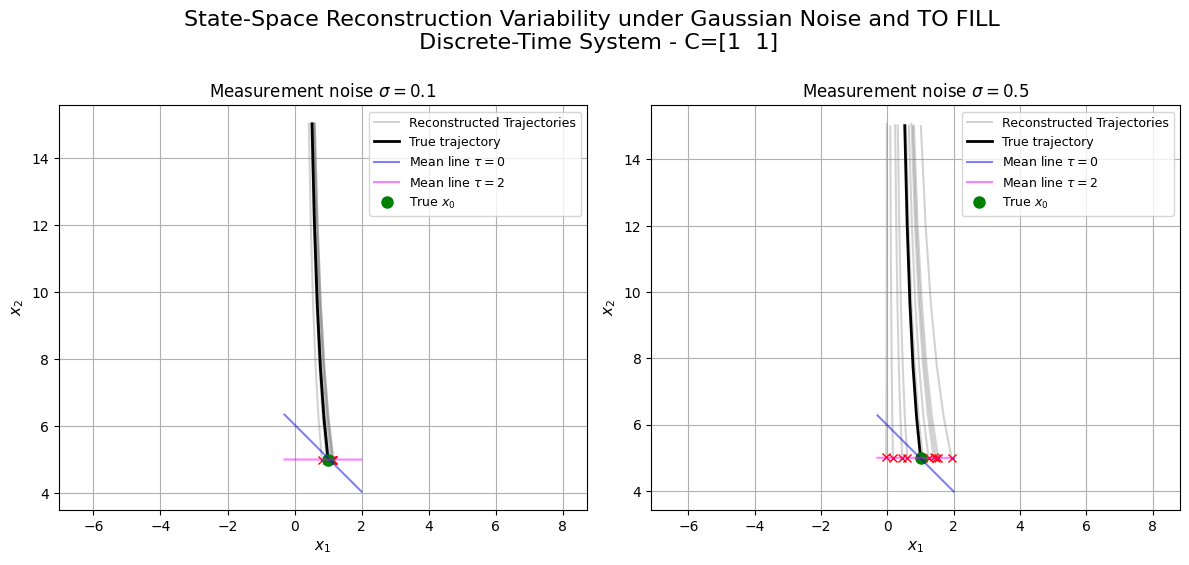

In [ ]:
a11, a22 = -1.3,2.2
A = np.diag([a11, a22])
C = np.array([1, 1])
T_max=5

#Solving
best_solutions = find_minimum_1_continuous(0, T_max, a11, a22)
print(best_solutions)
x0_true = np.array([1, 5])  #initial state
tau1, tau2 = best_solutions[0]


plot_state_space_variability_I_continuous(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.5], trials=10)


tau1, tau2= (0,2)


plot_state_space_variability_I_continuous(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.5], trials=10)


In [ ]:
from scipy.linalg import expm

def f_Im_continuous(A, C, tau1, tau2):
    taus = [tau1, tau2]

    # Initialize Gramian
    W = np.zeros((A.shape[0], A.shape[0]))

    for tau in taus:
        A_tau = expm(A * tau)
        term = A_tau.T @ C.T @ C @ A_tau
        W += term

    # Regularization for stability
    try:
        W_inv = np.linalg.inv(W)
    except np.linalg.LinAlgError:
        print("Warning: Gramian is singular or ill-conditioned; adding small regularization.")
        W += 1e-8 * np.eye(W.shape[0])
        W_inv = np.linalg.inv(W)

    return np.trace(W_inv)

def find_minimum_Im_continuous(tau_min, tau_max, A, C, resolution=50):
    best_value = np.inf
    best_solutions = []

    tau_grid = np.linspace(tau_min, tau_max, resolution)

    for tau1 in tau_grid:
        for tau2 in tau_grid:
            if abs(tau1 - tau2) < 1e-5:
                continue  # avoid amost equal sampling times
            obj_value = f_Im_continuous(A, C, tau1, tau2)

            if obj_value < best_value:
                best_value = obj_value
                best_solutions = [(tau1, tau2)]
            elif np.isclose(obj_value, best_value, atol=1e-8):
                best_solutions.append((tau1, tau2))

    return best_solutions


[(np.float64(9.183673469387756), np.float64(28.16326530612245)), (np.float64(9.795918367346939), np.float64(20.816326530612244)), (np.float64(9.795918367346939), np.float64(28.775510204081634)), (np.float64(10.408163265306122), np.float64(21.42857142857143)), (np.float64(10.408163265306122), np.float64(29.387755102040817)), (np.float64(11.020408163265307), np.float64(0.0)), (np.float64(11.020408163265307), np.float64(22.040816326530614)), (np.float64(11.020408163265307), np.float64(30.0)), (np.float64(11.63265306122449), np.float64(0.6122448979591837)), (np.float64(11.63265306122449), np.float64(22.653061224489797)), (np.float64(12.244897959183675), np.float64(1.2244897959183674)), (np.float64(12.244897959183675), np.float64(23.26530612244898)), (np.float64(12.857142857142858), np.float64(1.836734693877551)), (np.float64(12.857142857142858), np.float64(23.877551020408163)), (np.float64(13.46938775510204), np.float64(2.4489795918367347)), (np.float64(13.46938775510204), np.float64(24.48

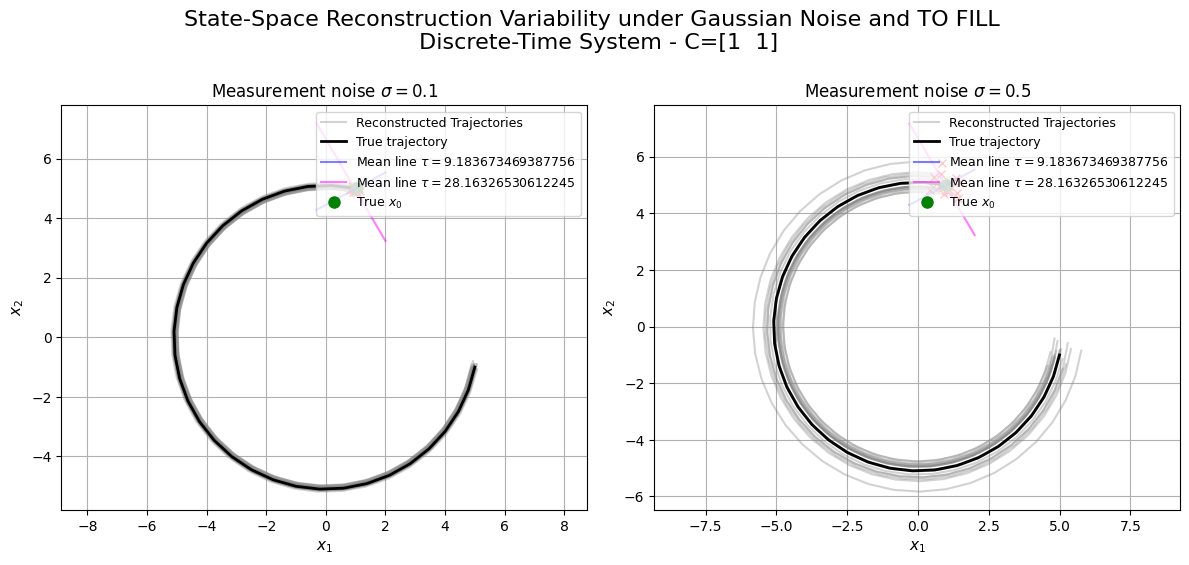

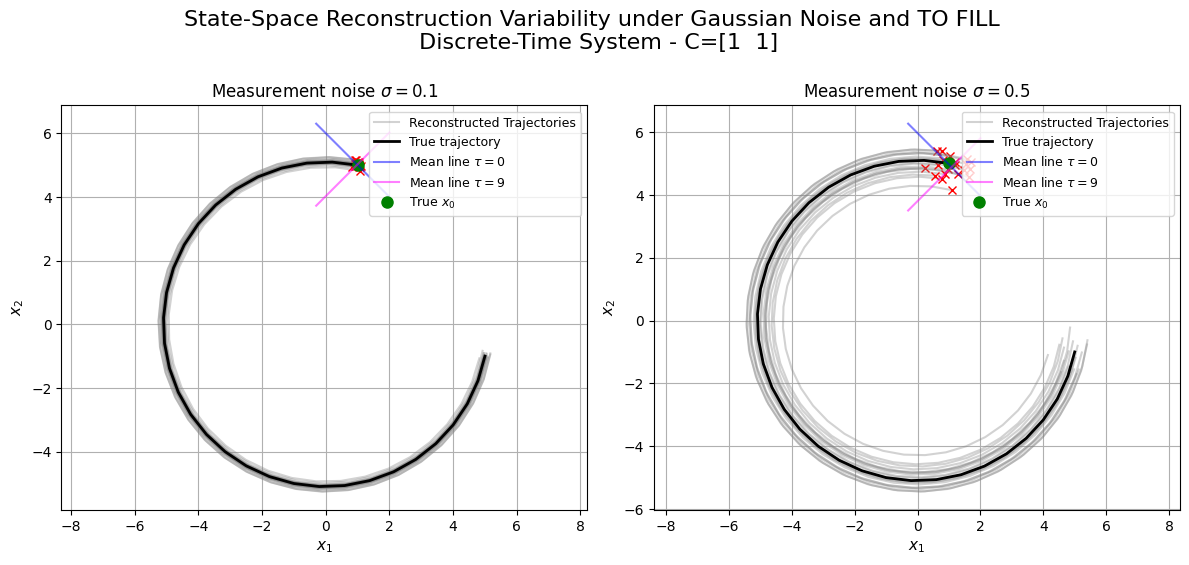

In [ ]:
theta = np.pi / 20
A=np.array([[0, -10*theta],
                     [10*theta, 0]])
C=np.array([1, 1])
C_r = C.reshape((1, 2))

T_max=30
#Solving
best_solutions = find_minimum_Im_continuous(0, T_max, A, C_r)
print(best_solutions)

x0_true = np.array([1, 5])  #initial state
tau1, tau2 = best_solutions[0]

plot_state_space_variability_I_continuous(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.5], trials=20)

tau1, tau2 = (0,9)


plot_state_space_variability_I_continuous(A,C, tau1, tau2, x0_true, T=T_max, sigmas=[0.1, 0.5], trials=20)
